Author: Diwash Dhakal
Created: 02/05/2021
Title: shift_angle_cm

# This Notebook reads in data files from a given directory and aligns them wrt the center of mass of k-beta peak 
output are the shifted data files in .txt format

In [1]:
import numpy as np
import os
import functions_pkpos as f
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pandas as pd
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
#from uncertainties import ufloat
%matplotlib notebook

read in reference file and make lists from the columns: energy_ref = energy & data_ref = counts per live

In [2]:
energy_ref, data_ref = f.read_file()

convert the energy values to angle values using Bragg's law

In [3]:
# args - a list of energy values and a float 'd' (interlayer distance); d  for Ge 555 is 0.0653269 nm
angle_ref = f.convert_to_angle(energy_ref, 0.0653269)  

#convert the lists to arrays  
angle_ref = np.array(angle_ref, dtype=float)
data_ref = np.array(data_ref, dtype=float)

#put everything into a dataframe
df_ref = pd.DataFrame()
df_ref['E_ref'] = energy_ref
df_ref['theta_ref'] = angle_ref
df_ref['data_ref'] = data_ref
df_ref

E_ref  theta_ref  data_ref
0    9546.471607  83.738675  0.001559
1    9546.714100  83.725424  0.001763
2    9546.956607  83.712201  0.001585
3    9547.199129  83.699006  0.001697
4    9547.441665  83.685838  0.001877
..           ...        ...       ...
596  9692.260548  78.260489 -0.000007
597  9692.506280  78.253501 -0.000010
598  9692.752015  78.246518 -0.000003
599  9692.997752  78.239538 -0.000014
600  9693.243491  78.232563 -0.000014

[601 rows x 3 columns]

Read in data files from specified directory

In [4]:
# can also make a list of directories for more than one sample as a future mod
directory = 'Averaged & Normalized'
path_directory = r"C:\Users\sawid\Research\Temperature-dependent-vtc\data-processing\rattrap_dataprocess\Averaged & Normalized"

In [5]:
# checks that the directory exists and throws error if not
assert os.path.exists(f'{path_directory}'), f'No directory with the name {directory} in specified path'

In [6]:
# generates a list of all the data files in specified directory
file_list = [f for f in os.listdir(path_directory) if 'norm' in f]
N = len(file_list)
print(N, file_list)


36 ['1m0m115c_norm.txt', '1m0m135c_norm.txt', '1m0m25C_norm.txt', '1m0m60C_norm.txt', '1m0m90C_norm.txt', '1m10m115C_norm.txt', '1m10m135C_norm.txt', '1m10m25C-controlled_norm.txt', '1m10m25C_norm.txt', '1m10m60C_norm.txt', '1m10m90C_norm.txt', '1m1m115c_norm.txt', '1m1m135c_norm.txt', '1m1m25C_norm.txt', '1m1m60C_norm.txt', '1m1m90C_norm.txt', '1m2m115C_norm.txt', '1m2m135C_norm.txt', '1m2m25C_norm.txt', '1m2m60C_norm.txt', '1m2m90C_norm.txt', '1m3m115c_norm.txt', '1m3m135c_norm.txt', '1m3m25C_norm.txt', '1m3m60C_norm.txt', '1m3m90C_norm.txt', '1m5m115c_norm.txt', '1m5m135c_norm.txt', '1m5m25C_norm.txt', '1m5m60C_norm.txt', '1m5m90C_norm.txt', '1mzntfms115c_norm.txt', '1mzntfms135c_norm.txt', '1mzntfms25C_norm.txt', '1ZnNO32_0p2m_norm_shifted_renorm_shifted.txt', '4ZnCl2_1m_LiCl_10m_norm_shifted_renorm_shifted.txt']


In [7]:
# Load in data into a new dataframe
df = pd.DataFrame()
# extract energy from the first data file
energies = []
for point in np.array(f.read_data_file(f'{path_directory}/{file_list[0]}')):
    energies.append(float(point[0]))
df['Energy'] = energies

for filename in file_list:
    data = []
    for x in np.array(f.read_data_file(f'{path_directory}/{filename}')):
        data.append(float(x[1]))
    df[filename] = data
        
df

Energy  1m0m115c_norm.txt  1m0m135c_norm.txt  1m0m25C_norm.txt  \
0    9550.00           0.001638           0.001524          0.001645   
1    9550.25           0.001593           0.001879          0.001572   
2    9550.50           0.001876           0.001457          0.001718   
3    9550.75           0.001445           0.001744          0.001645   
4    9551.00           0.001906           0.001744          0.001587   
..       ...                ...                ...               ...   
596  9699.00          -0.000011           0.000006         -0.000028   
597  9699.25          -0.000042          -0.000040         -0.000011   
598  9699.50           0.000001          -0.000011         -0.000011   
599  9699.75           0.000012          -0.000014         -0.000041   
600  9700.00           0.000021          -0.000017          0.000024   

     1m0m60C_norm.txt  1m0m90C_norm.txt  1m10m115C_norm.txt  \
0        1.748504e-03          0.001827            0.001701   
1        1.600849e-03          0.001483            0.001444   
2        1.674629e-03          0.001874            0.001216   
3        1.748479e-03          0.001602            0.001216   
4        1.615778e-03          0.001756            0.001701   
..                ...               ...                 ...   
596      4.858787e-07         -0.000015           -0.000035   
597     -1.008040e-06         -0.000032            0.000034   
598     -5.479854e-05         -0.000013            0.000014   
599      1.244051e-05         -0.000010           -0.000049   
600     -4.284339e-05         -0.000031            0.000014   

     1m10m135C_norm.txt  1m10m25C-controlled_norm.txt  1m10m25C_norm.txt  ...  \
0          1.689805e-03                      0.001814           0.001991  ...   
1          1.548864e-03                      0.001459           0.002299  ...   
2          1.831362e-03                      0.001374           0.001930  ...   
3          1.830932e-03                      0.002102           0.001684  ...   
4          1.831060e-03                      0.001239           0.001684  ...   
..                  ...                           ...                ...  ...   
596       -3.274211e-05                     -0.000035          -0.000049  ...   
597        5.935102e-07                     -0.000047          -0.000042  ...   
598       -8.930306e-06                      0.000052          -0.000033  ...   
599        5.350782e-06                     -0.000035          -0.000018  ...   
600       -5.177702e-05                      0.000018           0.000035  ...   

     1m5m115c_norm.txt  1m5m135c_norm.txt  1m5m25C_norm.txt  1m5m60C_norm.txt  \
0             0.001713           0.001627          0.001772      1.695517e-03   
1             0.001754           0.001647          0.001503      1.469765e-03   
2             0.001733           0.001608          0.001522      1.864557e-03   
3             0.001854           0.001687          0.001887      1.554407e-03   
4             0.001673           0.001667          0.001580      1.300648e-03   
..                 ...                ...               ...               ...   
596          -0.000004          -0.000015         -0.000026     -7.897874e-07   
597          -0.000061          -0.000011          0.000003     -1.218637e-05   
598           0.000010          -0.000042         -0.000011     -7.831668e-07   
599          -0.000034           0.000011         -0.000007     -2.644172e-05   
600           0.000022          -0.000025         -0.000013      8.189850e-05   

     1m5m90C_norm.txt  1mzntfms115c_norm.txt  1mzntfms135c_norm.txt  \
0        1.369676e-03               0.001607               0.001660   
1        2.079432e-03               0.001454               0.001815   
2        1.873306e-03               0.001485               0.001830   
3        1.827309e-03               0.001363               0.001598   
4        1.392084e-03               0.001851               0.001521   
..          

<IPython.core.display.Javascript object>


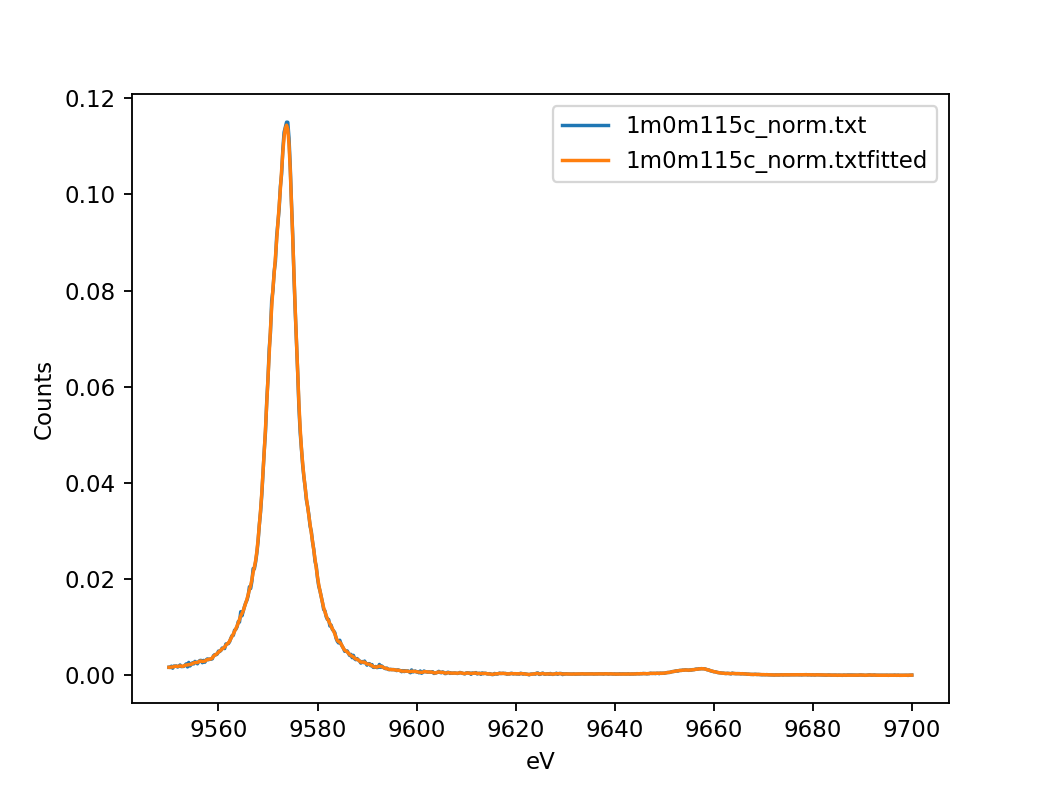

peak value: 9573.75


<IPython.core.display.Javascript object>


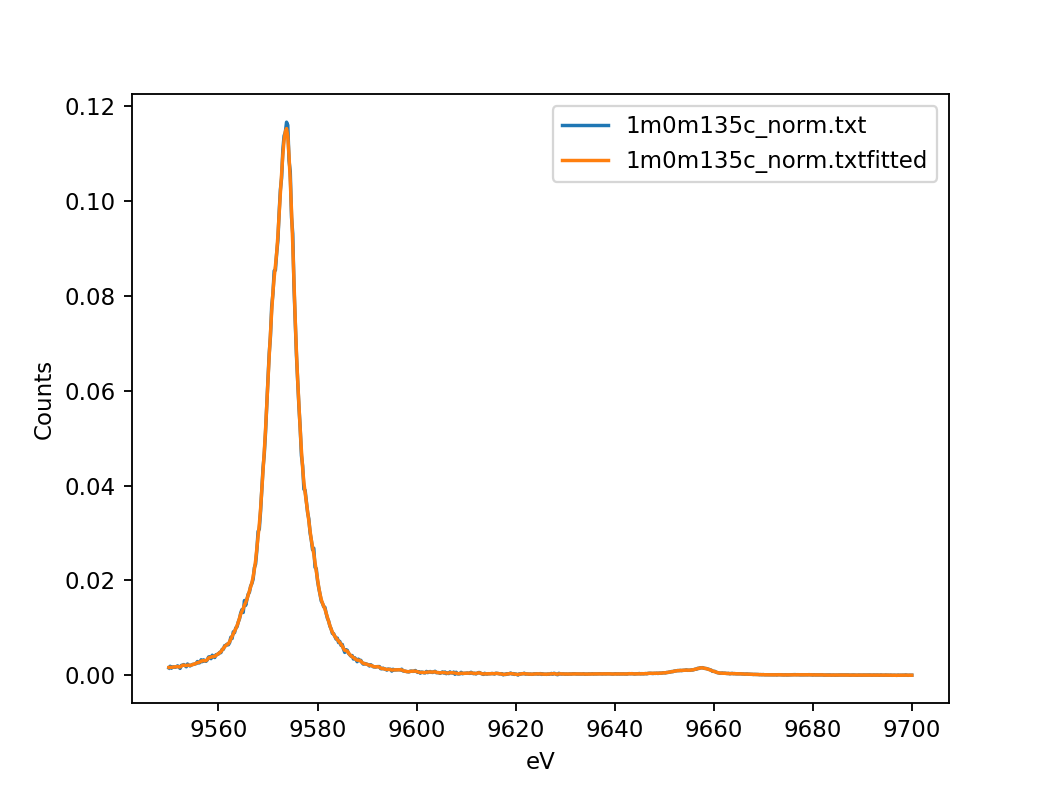

peak value: 9573.75


<IPython.core.display.Javascript object>


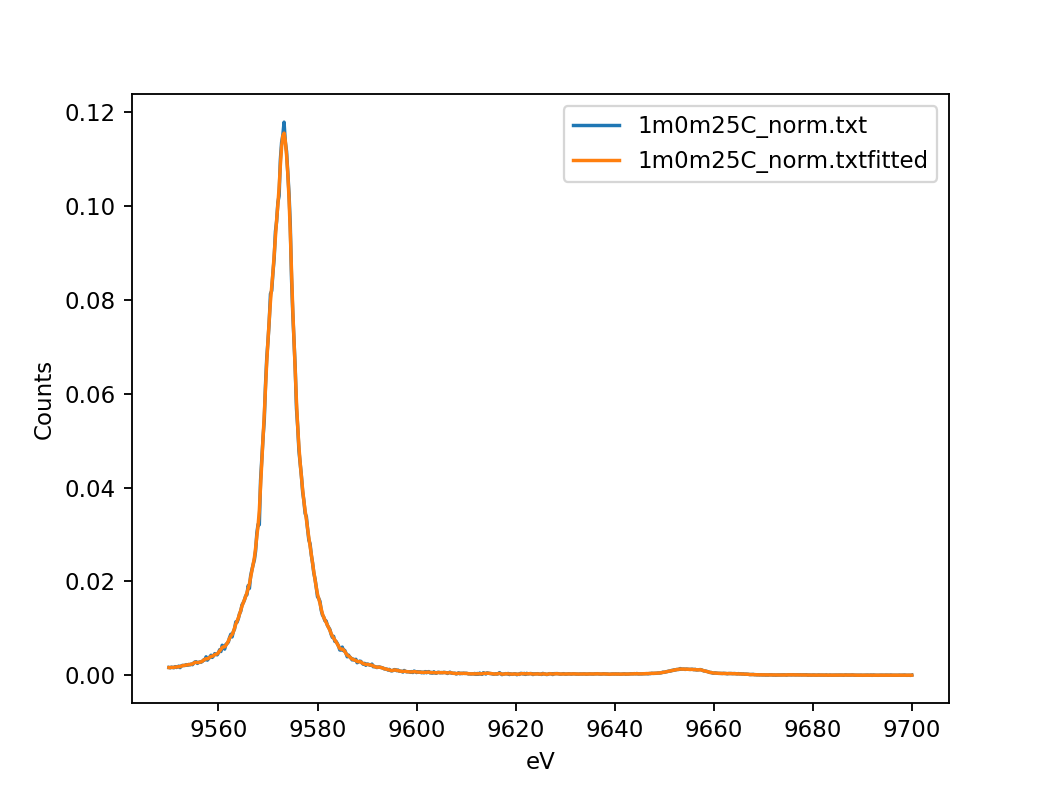

peak value: 9573.25


<IPython.core.display.Javascript object>


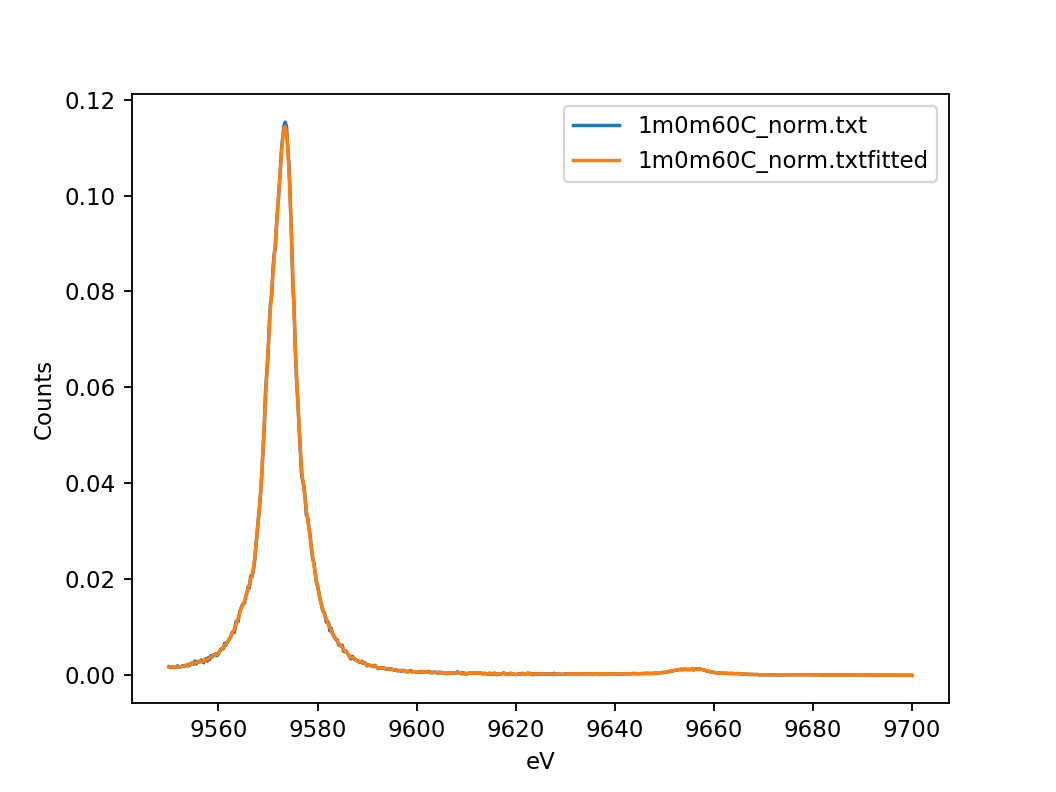

peak value: 9573.5


<IPython.core.display.Javascript object>


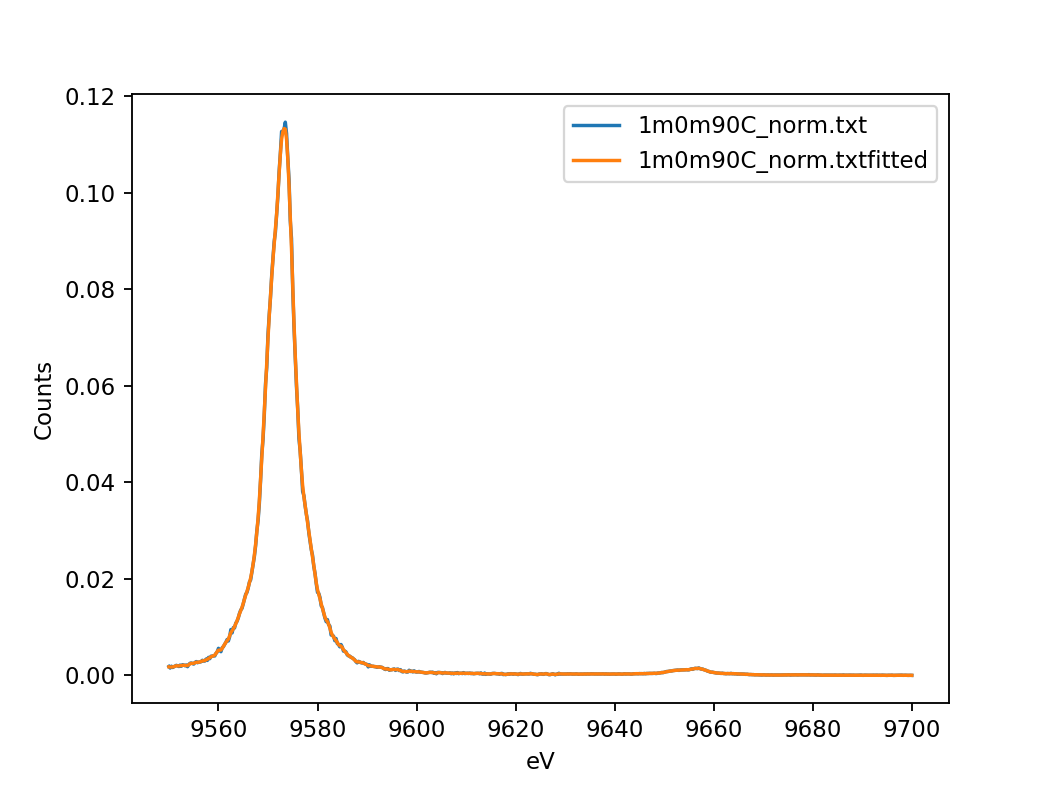

peak value: 9573.25


<IPython.core.display.Javascript object>


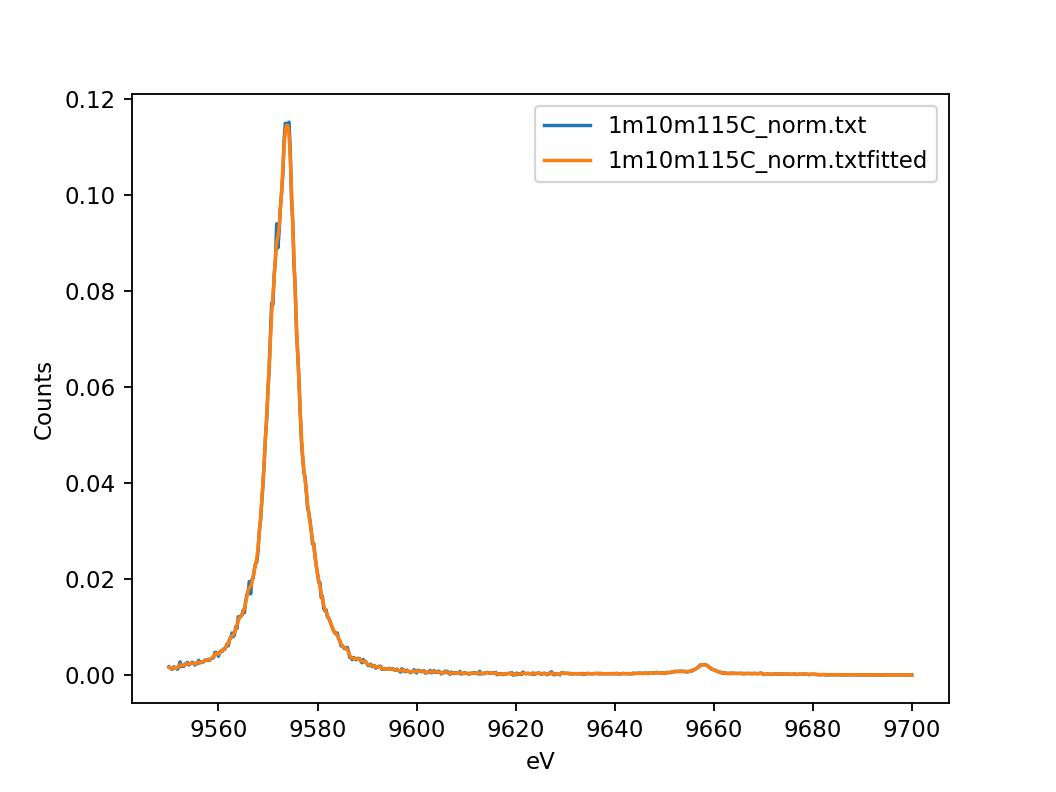

peak value: 9573.75


<IPython.core.display.Javascript object>


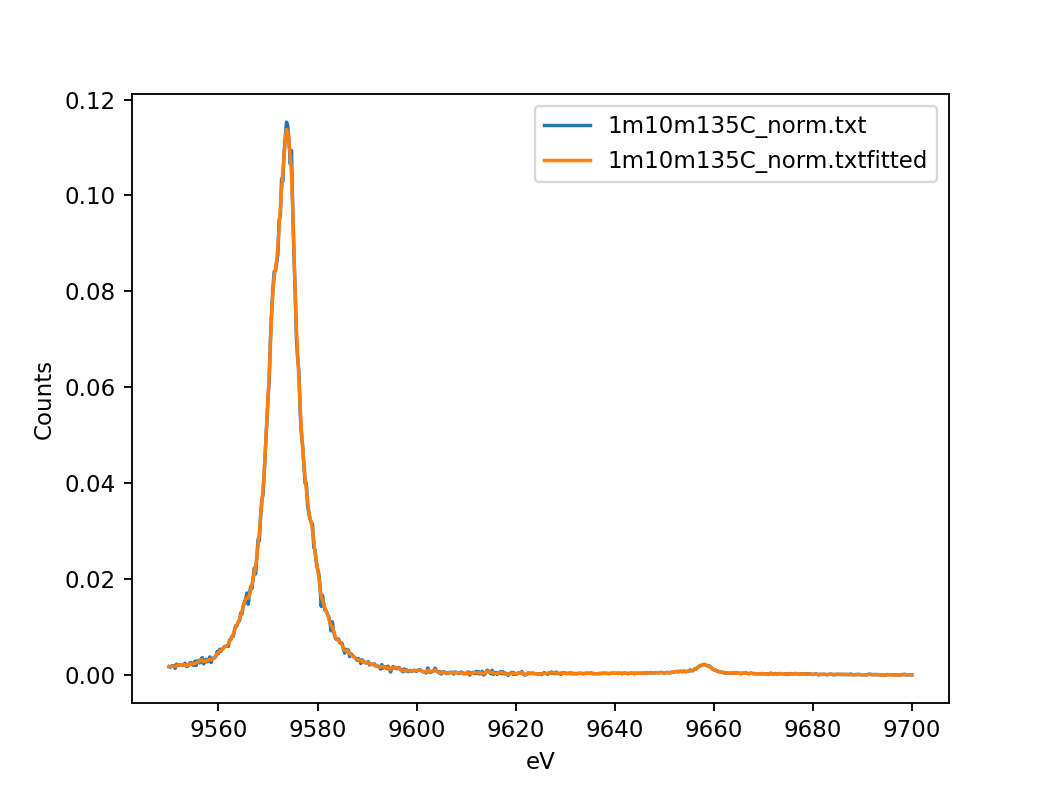

peak value: 9573.75


<IPython.core.display.Javascript object>


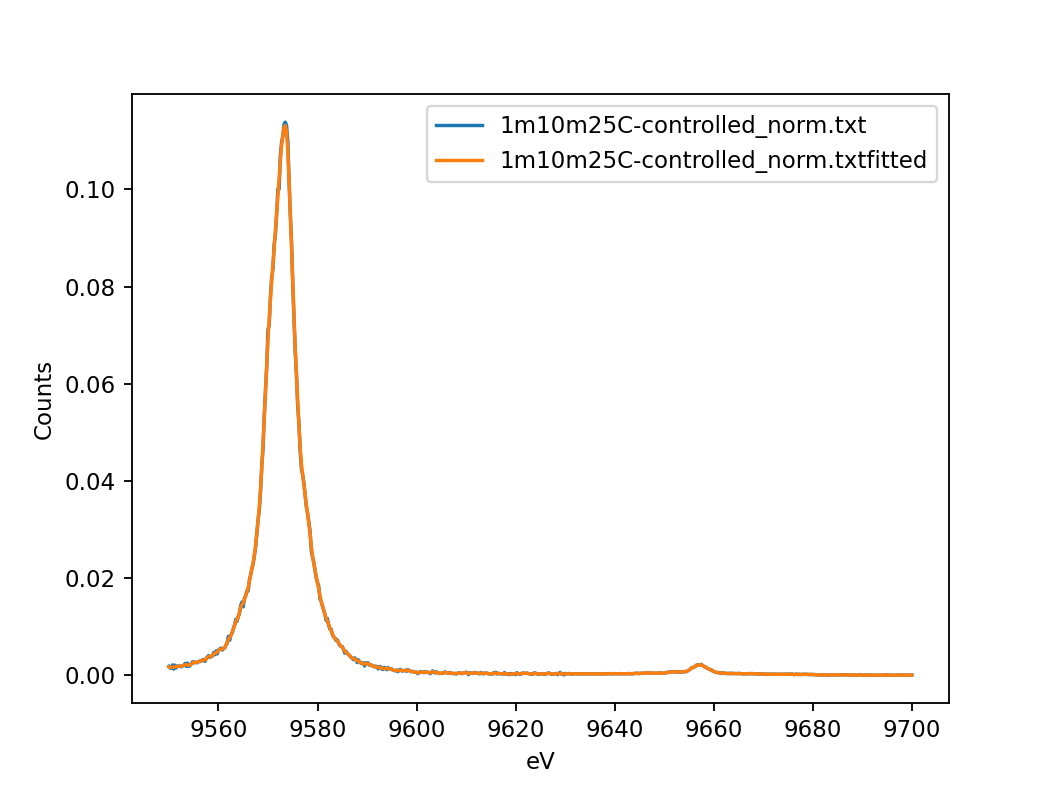

peak value: 9573.5


<IPython.core.display.Javascript object>


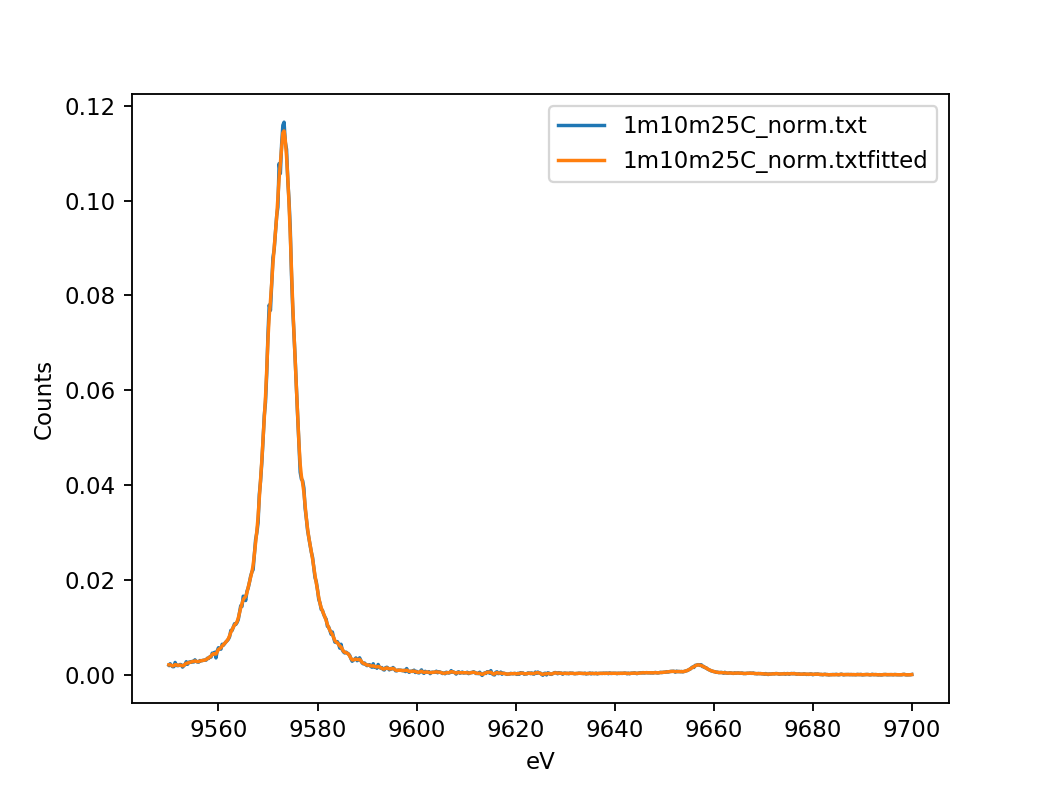

peak value: 9573.25


<IPython.core.display.Javascript object>


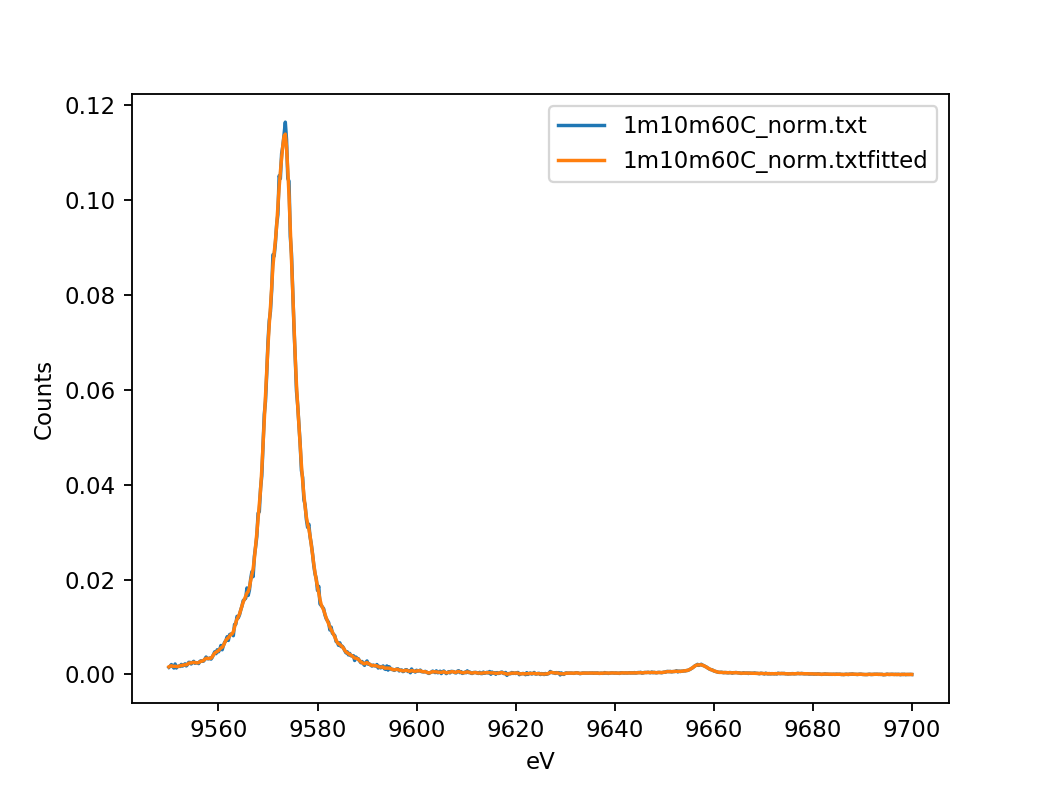

peak value: 9573.5


<IPython.core.display.Javascript object>


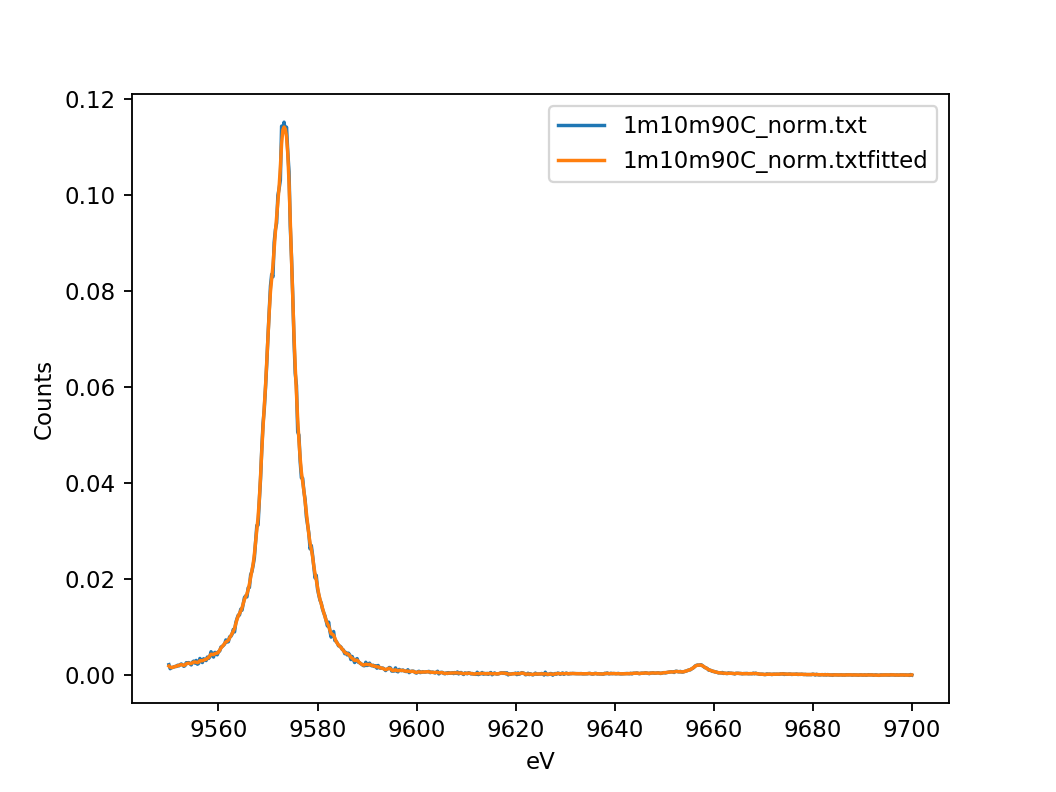

peak value: 9573.25


<IPython.core.display.Javascript object>


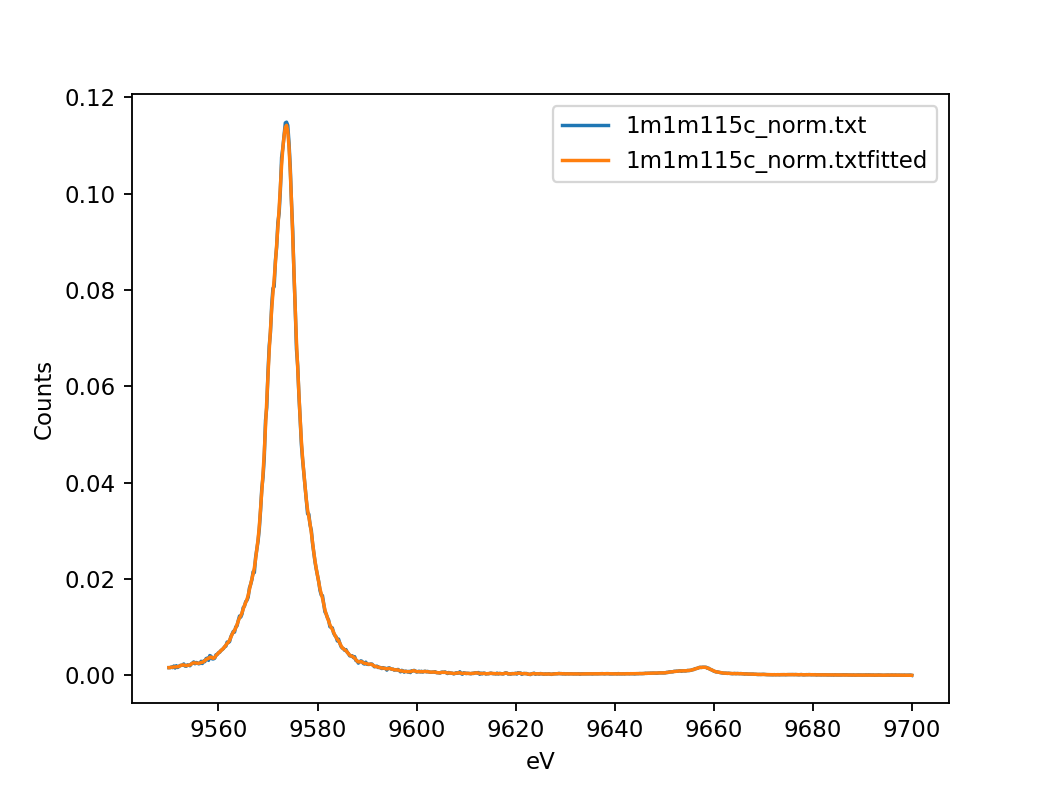

peak value: 9573.75


<IPython.core.display.Javascript object>


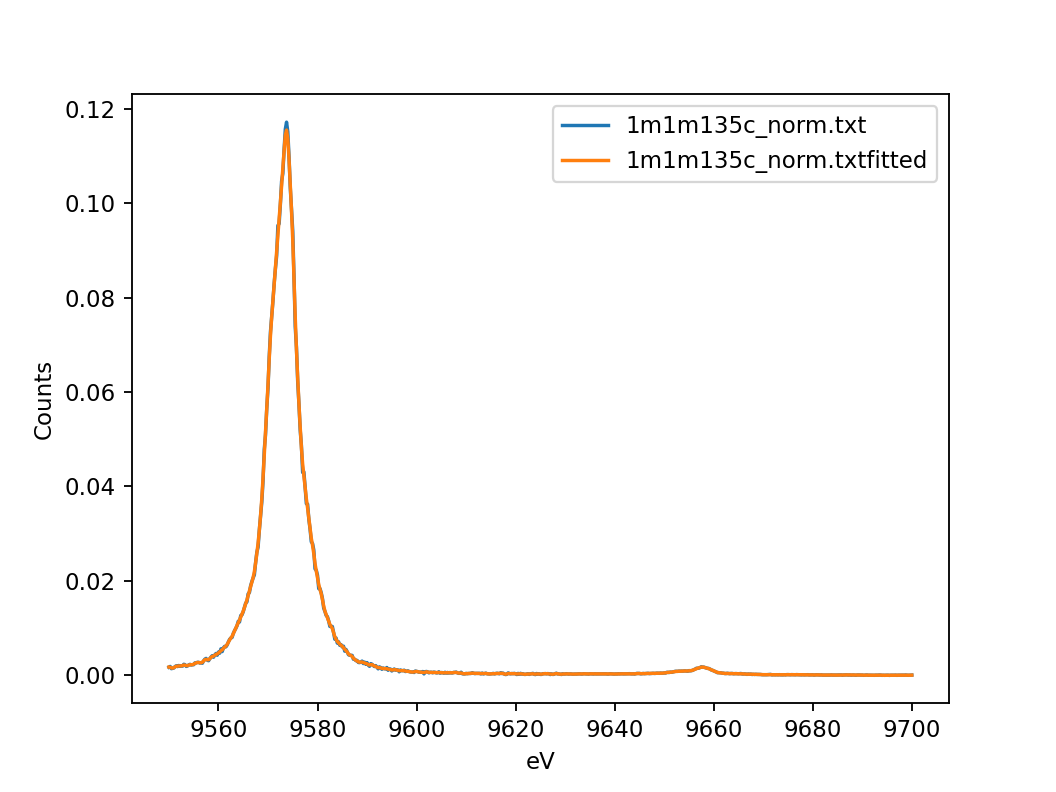

peak value: 9573.75


<IPython.core.display.Javascript object>


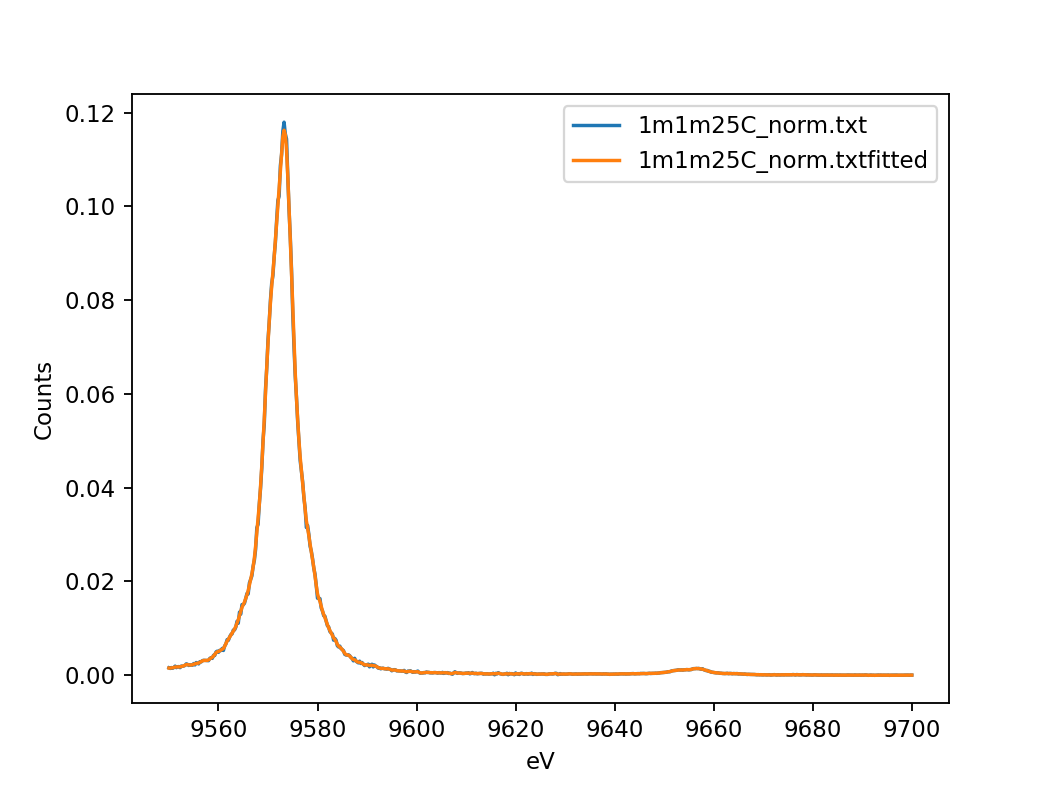

peak value: 9573.25


<IPython.core.display.Javascript object>


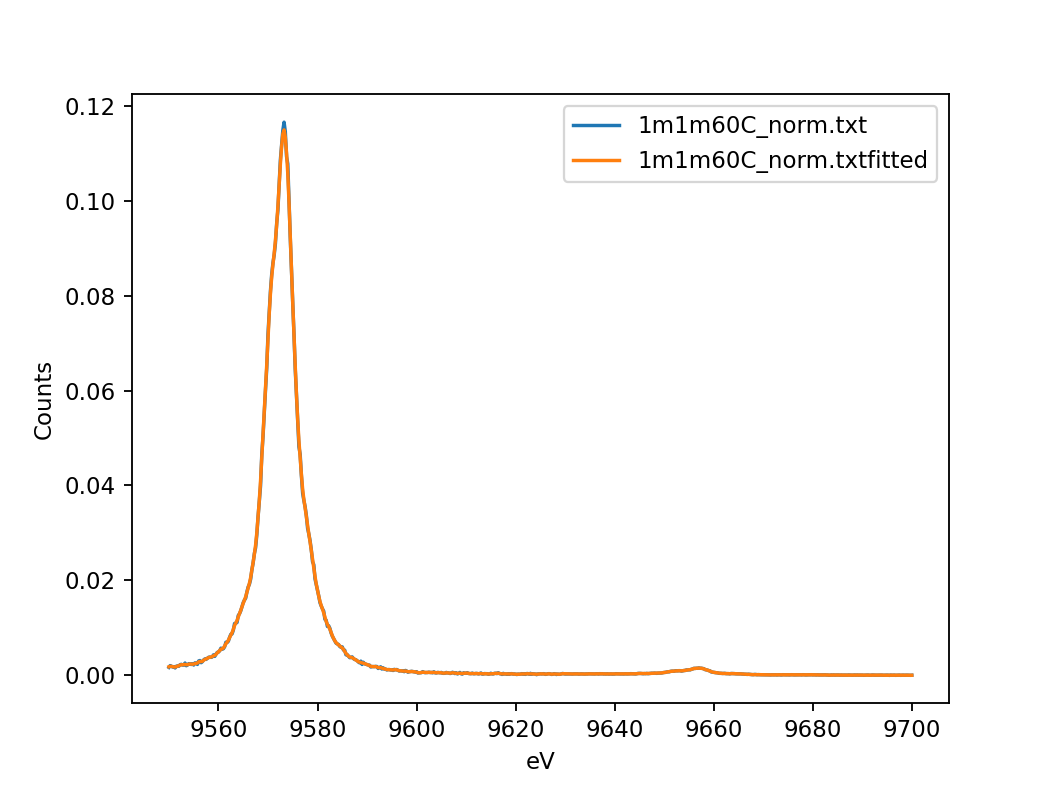

peak value: 9573.25


<IPython.core.display.Javascript object>


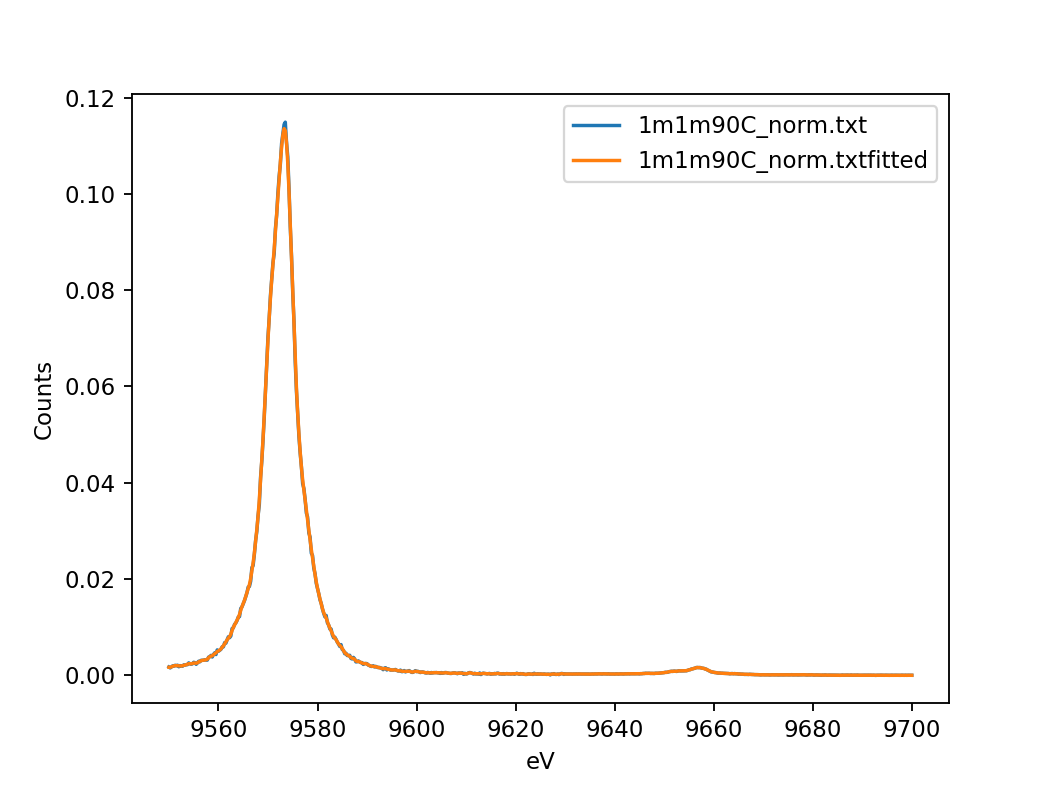

peak value: 9573.25


<IPython.core.display.Javascript object>


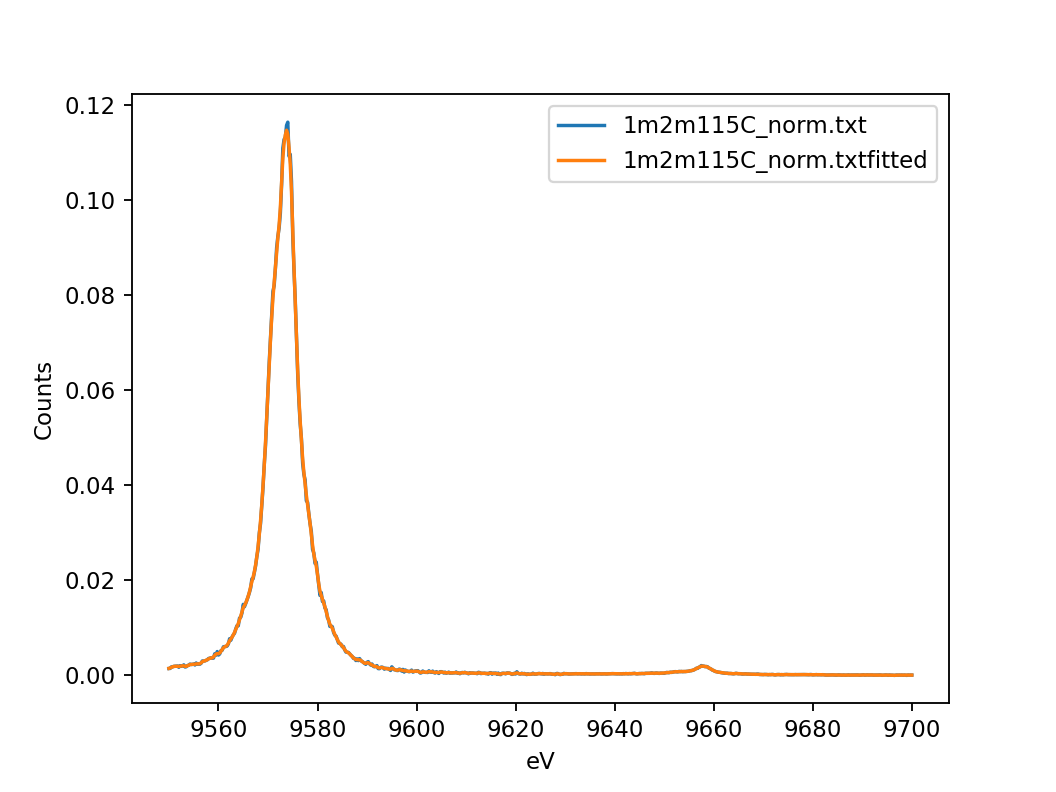

peak value: 9573.75


<IPython.core.display.Javascript object>


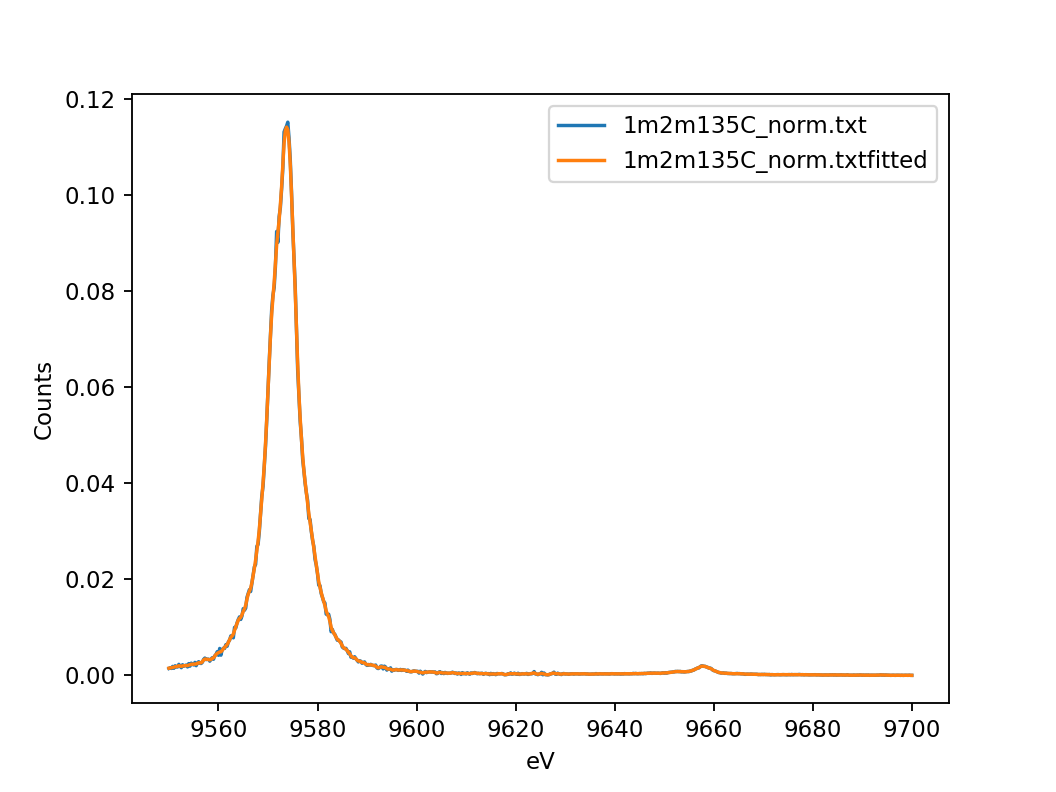

peak value: 9573.75


<IPython.core.display.Javascript object>


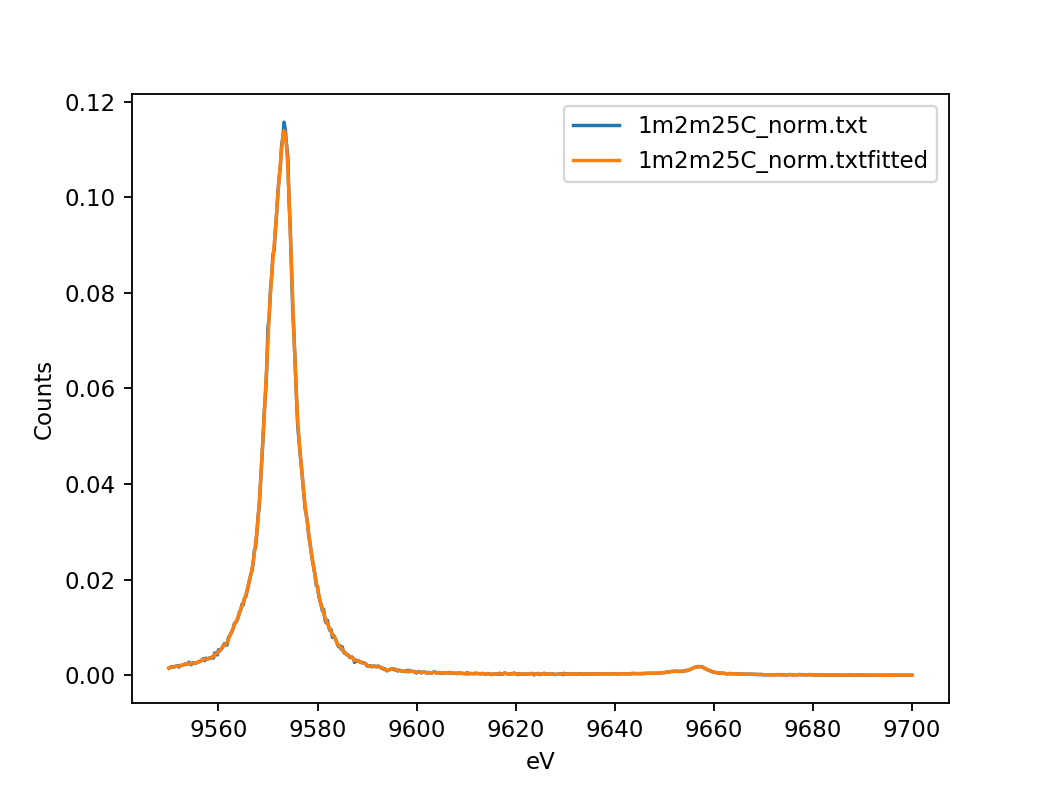

peak value: 9573.25


<IPython.core.display.Javascript object>


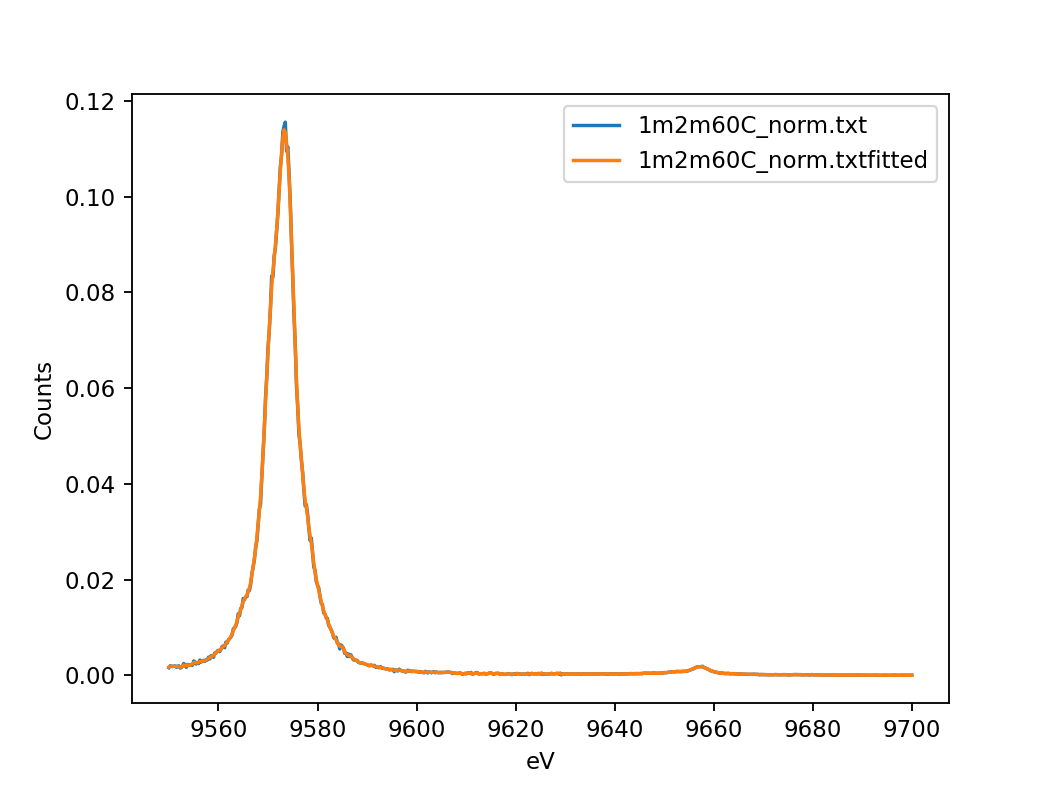

peak value: 9573.25


C:\Users\sawid\AppData\Local\Temp\ipykernel_46836\2775346732.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(file)


<IPython.core.display.Javascript object>


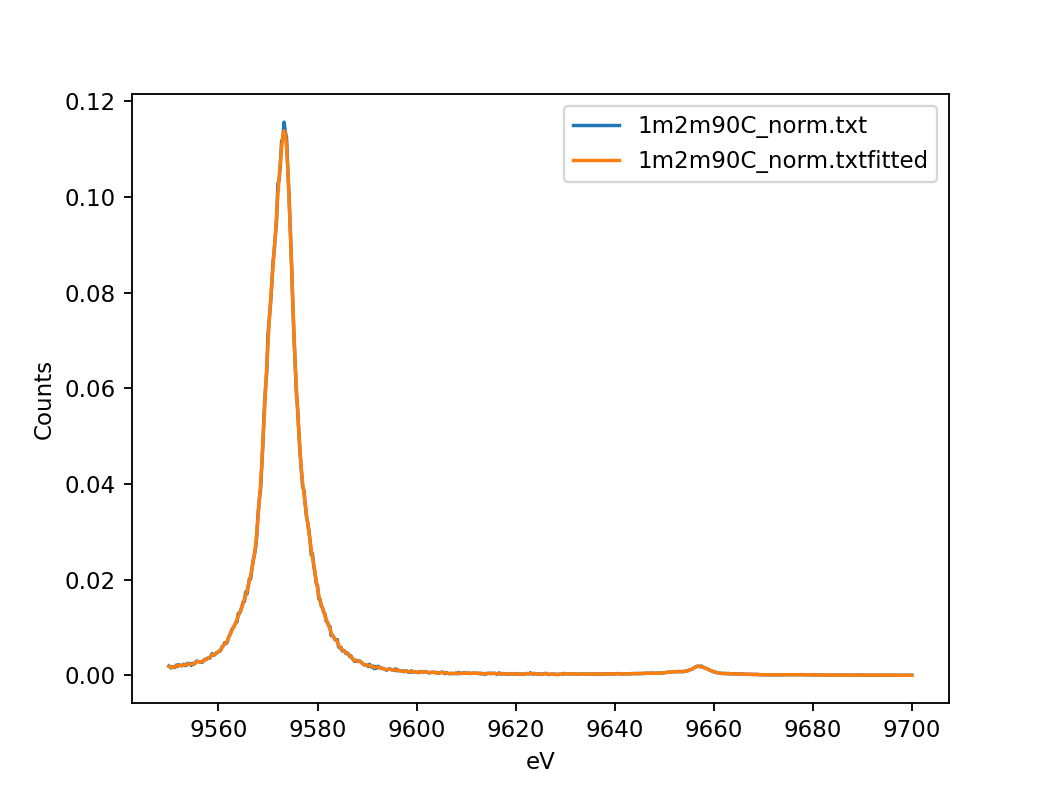

peak value: 9573.25


<IPython.core.display.Javascript object>


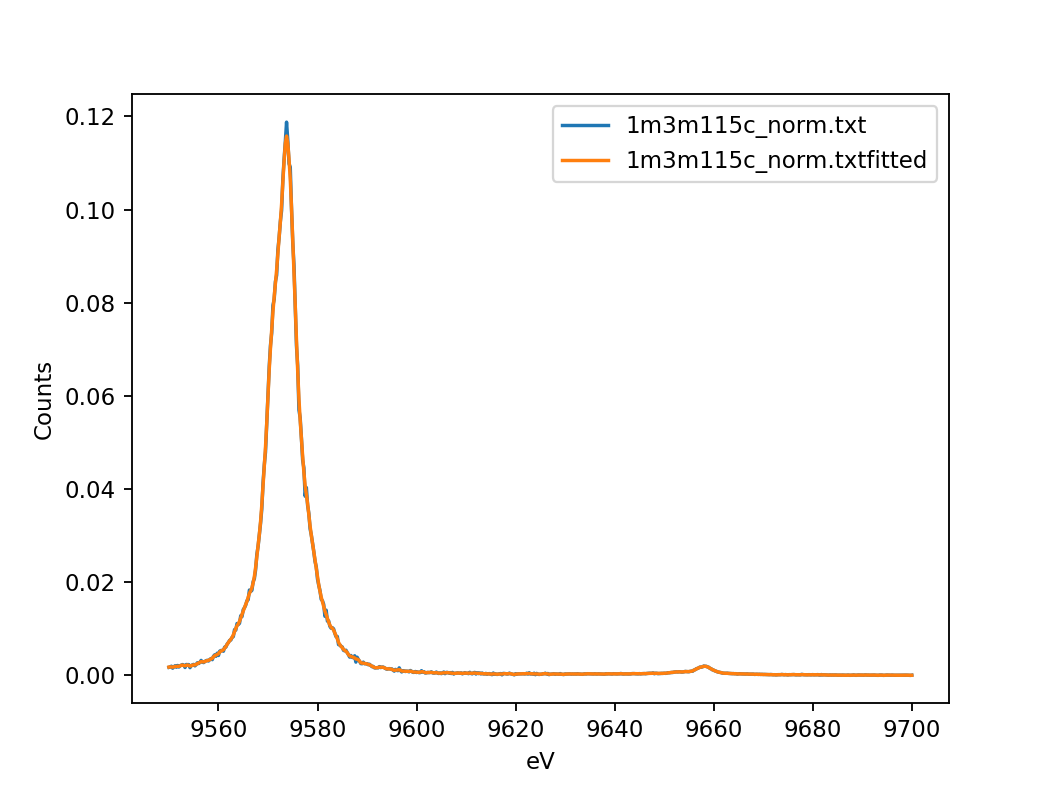

peak value: 9573.75


<IPython.core.display.Javascript object>


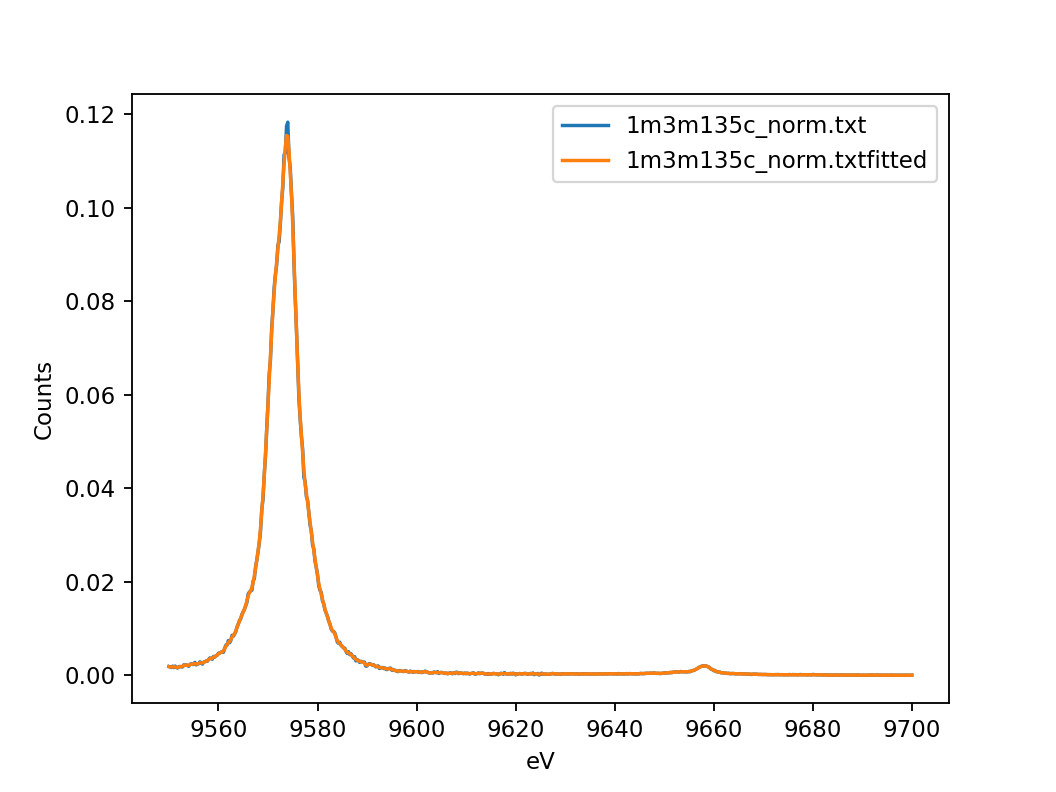

peak value: 9573.75


<IPython.core.display.Javascript object>


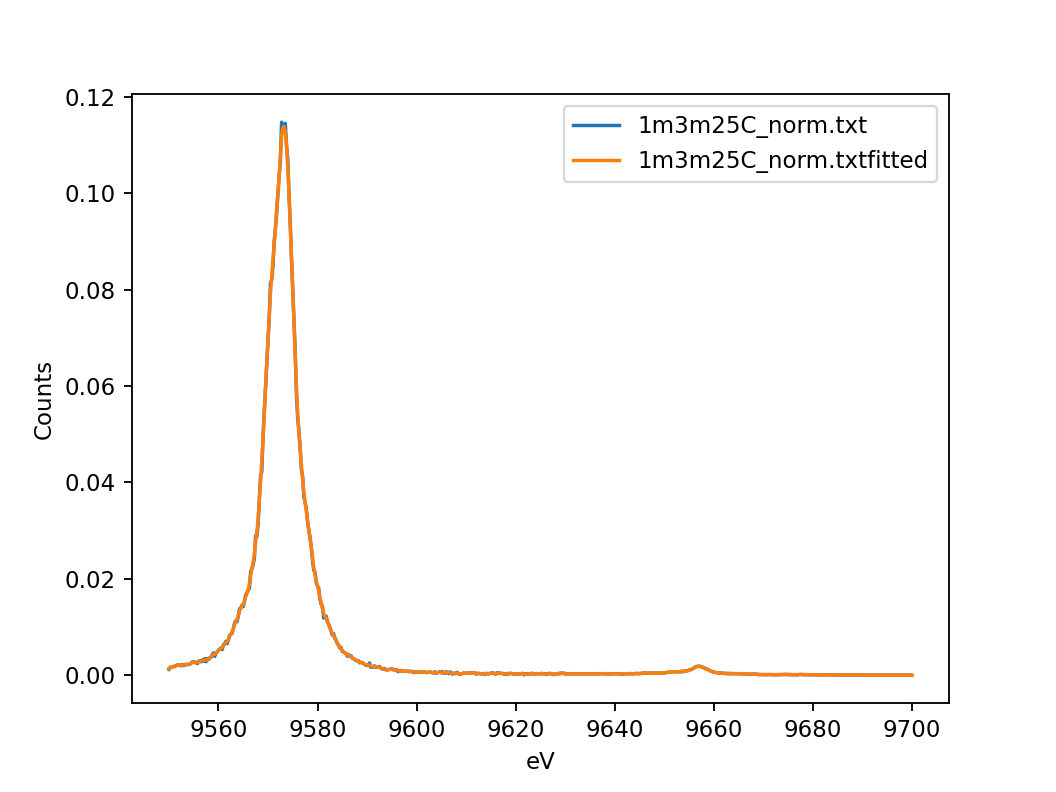

peak value: 9573.25


<IPython.core.display.Javascript object>


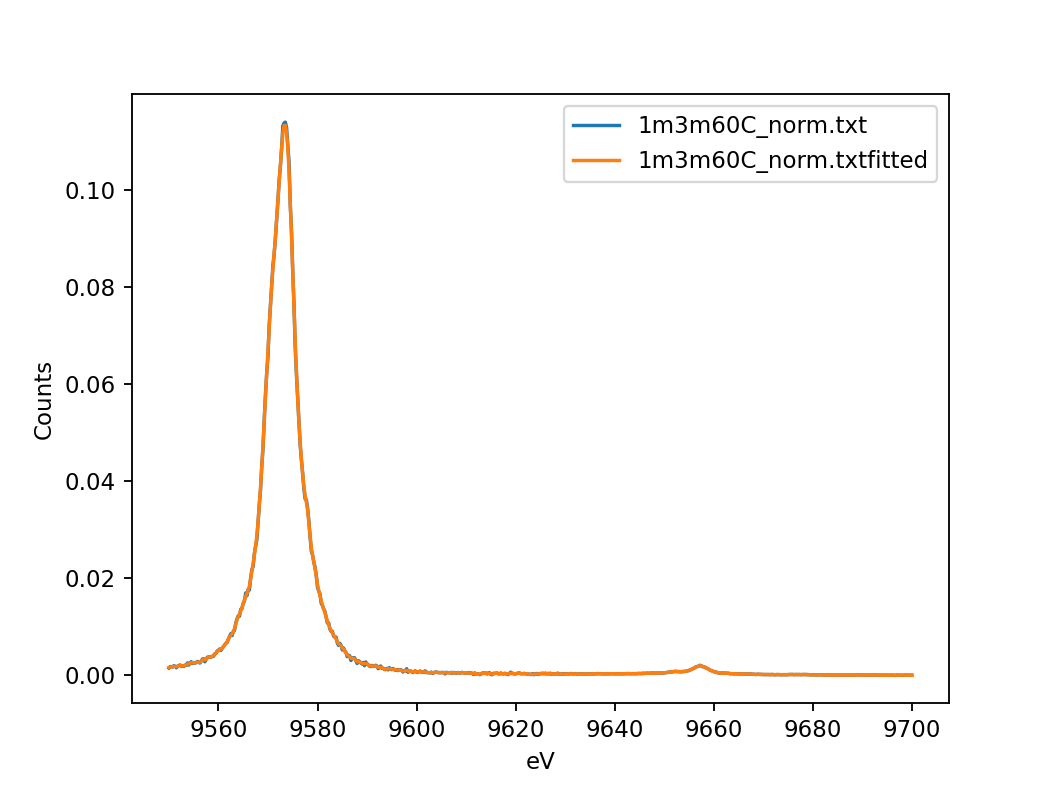

peak value: 9573.5


<IPython.core.display.Javascript object>


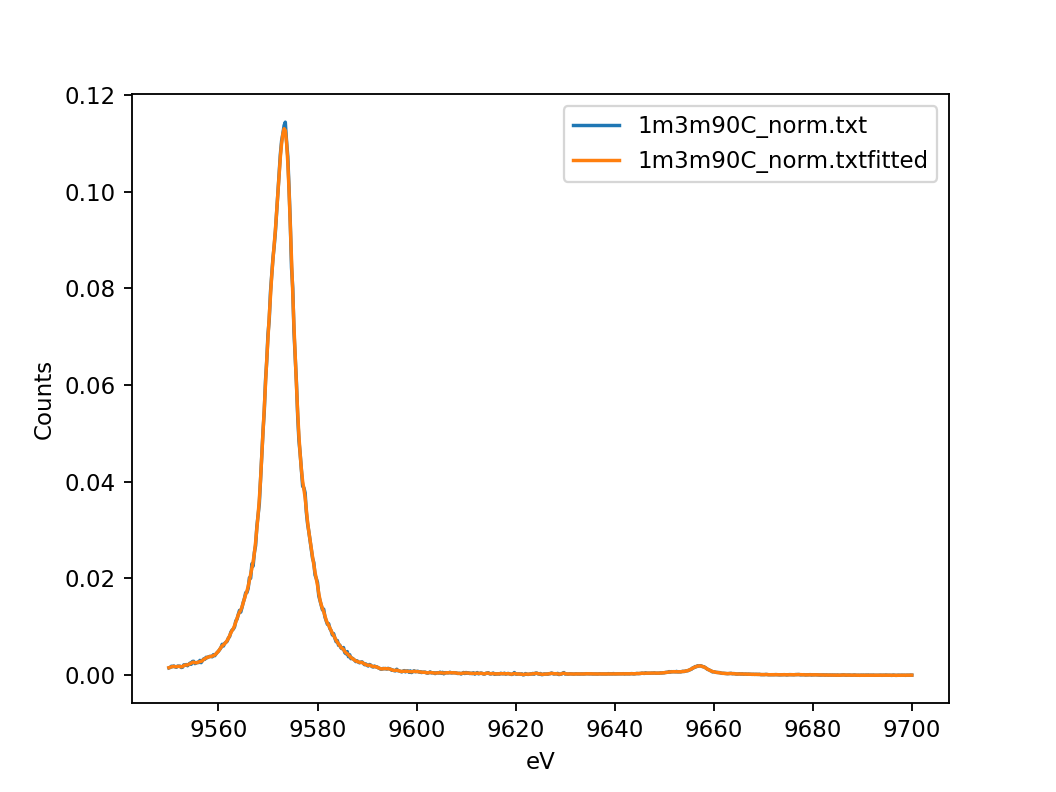

peak value: 9573.25


<IPython.core.display.Javascript object>


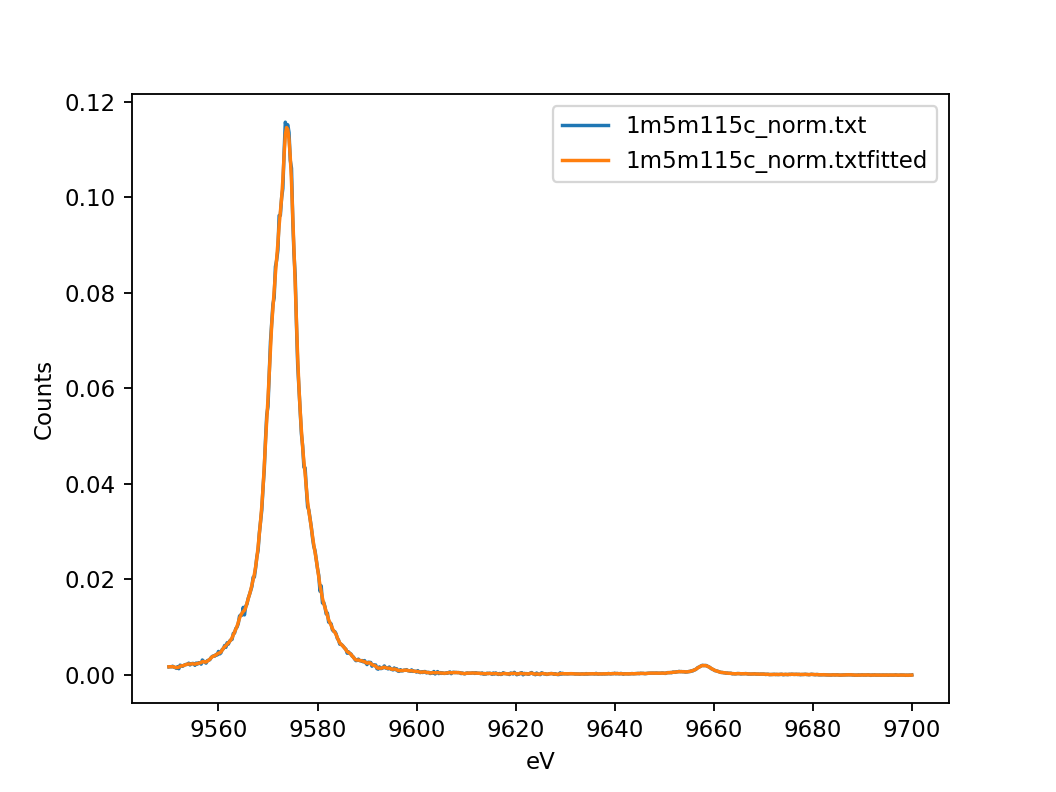

peak value: 9573.75


<IPython.core.display.Javascript object>


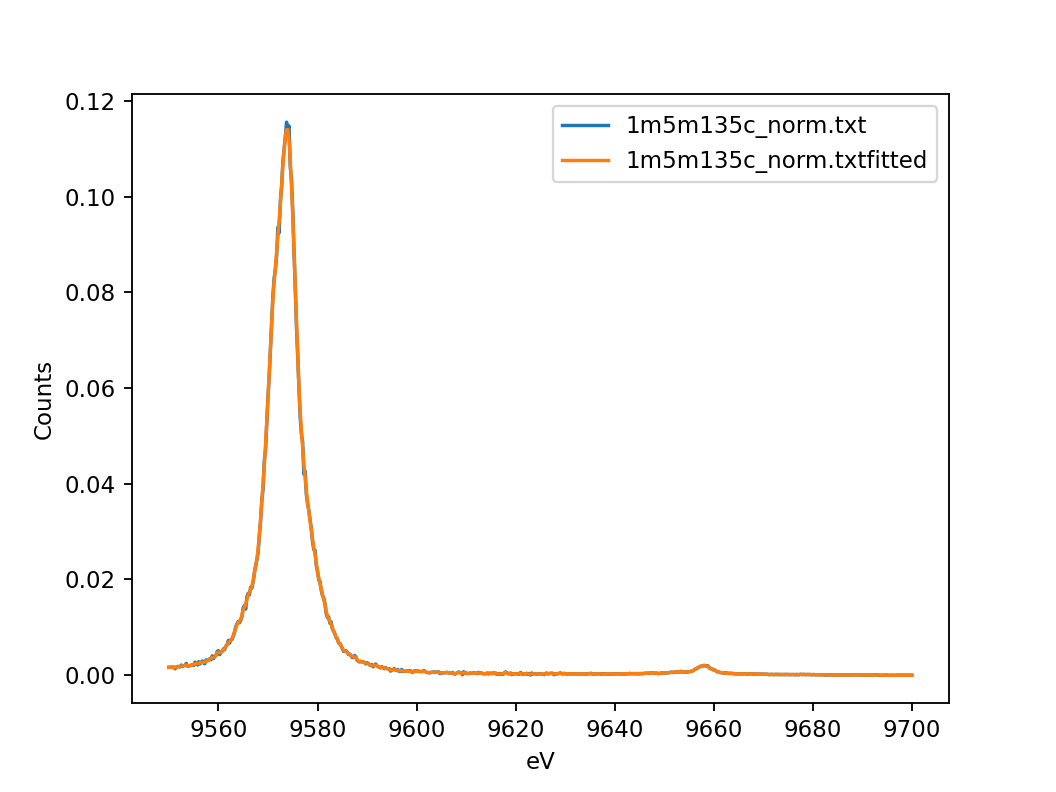

peak value: 9574.0


<IPython.core.display.Javascript object>


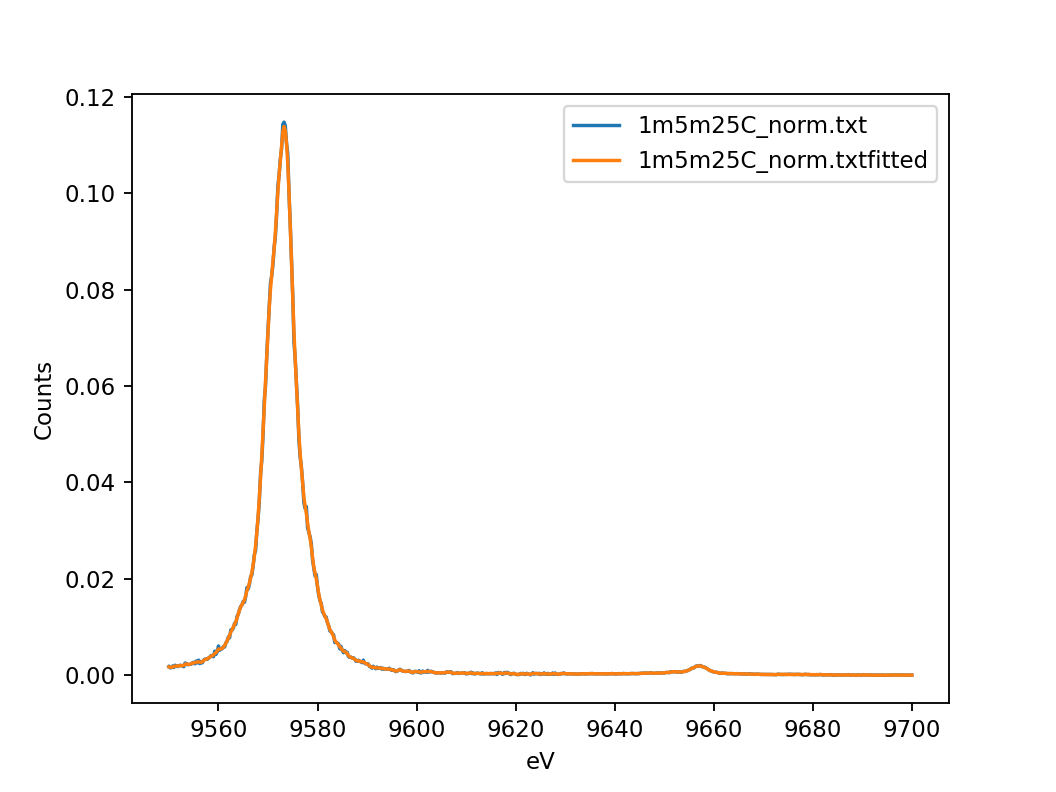

peak value: 9573.25


<IPython.core.display.Javascript object>


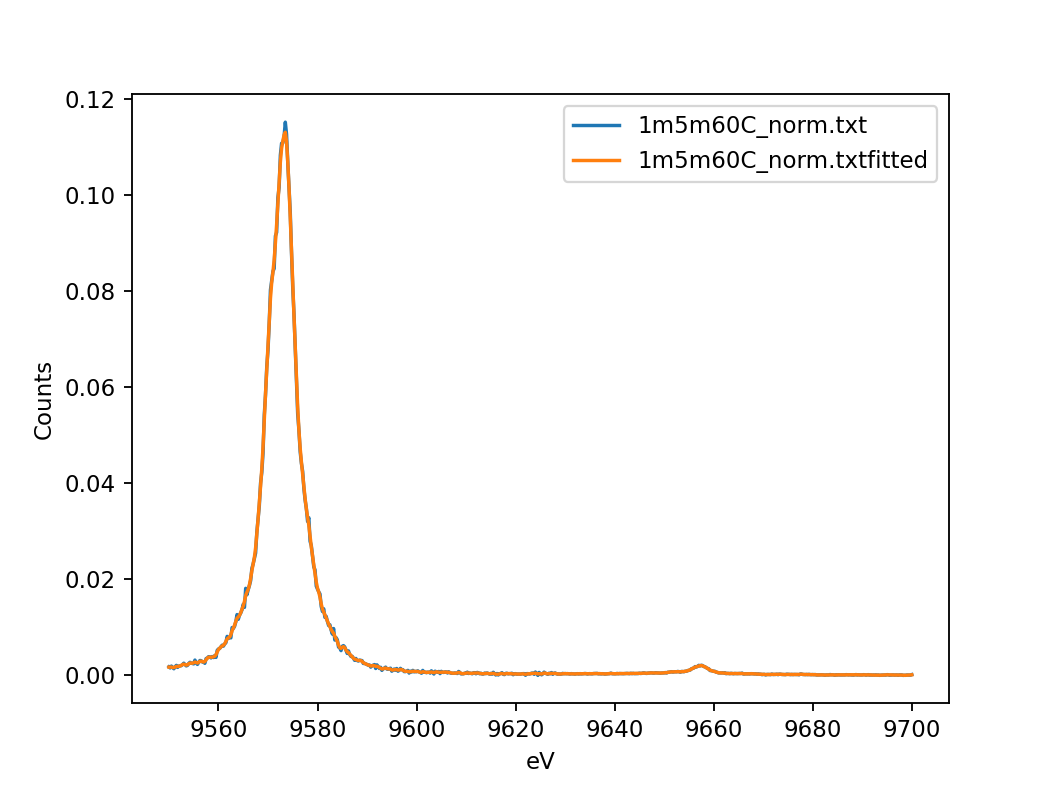

peak value: 9573.5


<IPython.core.display.Javascript object>


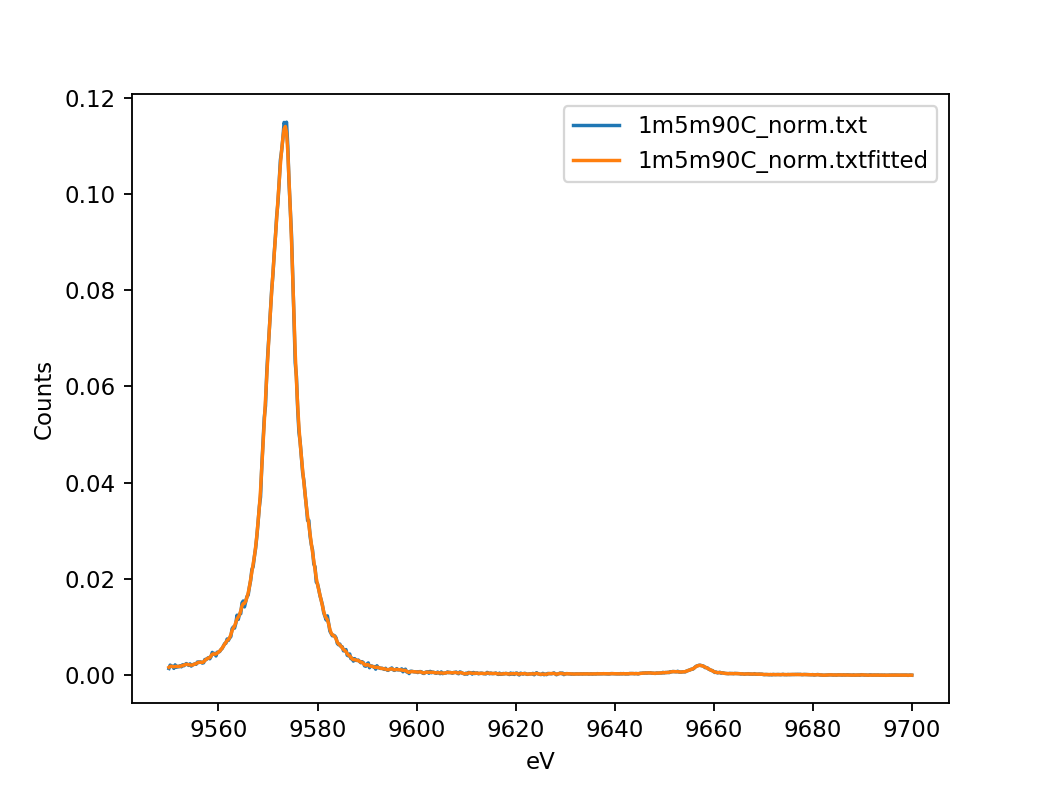

peak value: 9573.5


<IPython.core.display.Javascript object>


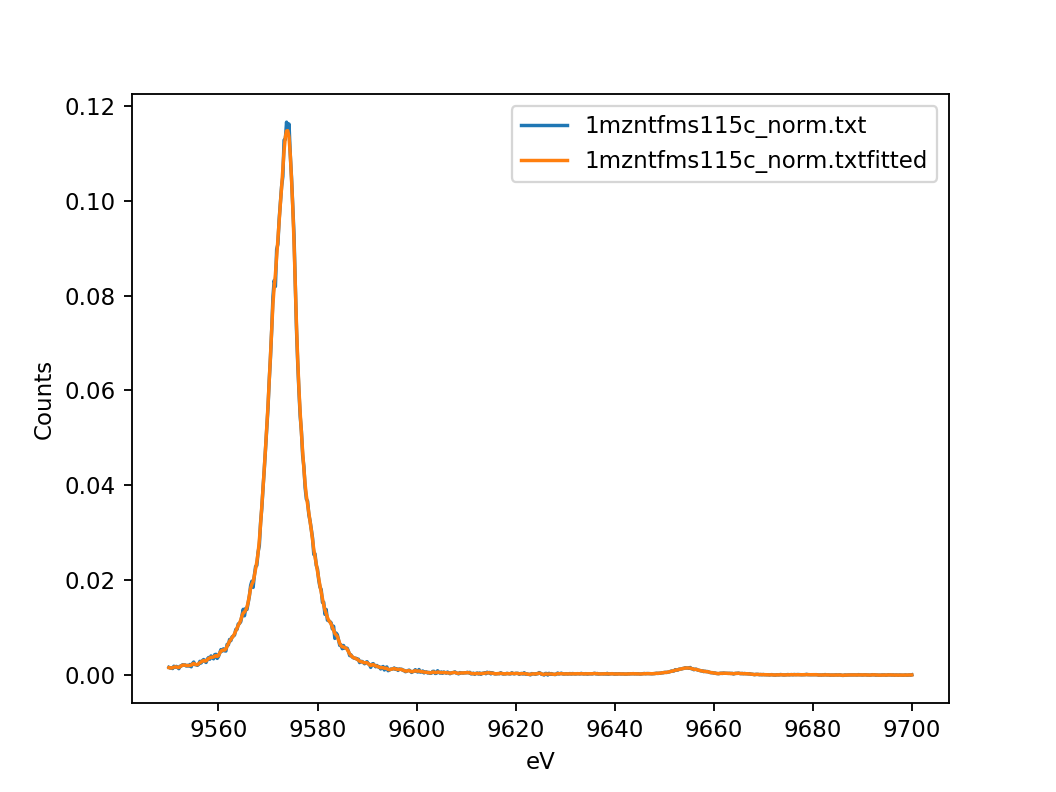

peak value: 9574.0


<IPython.core.display.Javascript object>


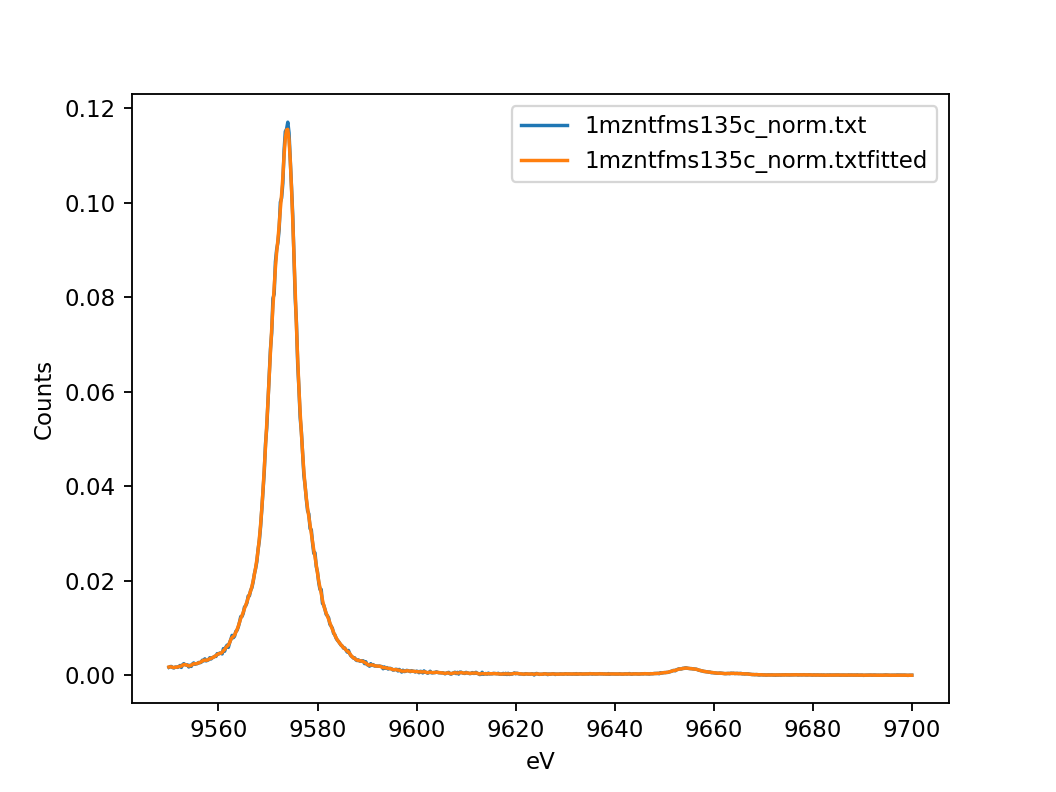

peak value: 9574.0


<IPython.core.display.Javascript object>


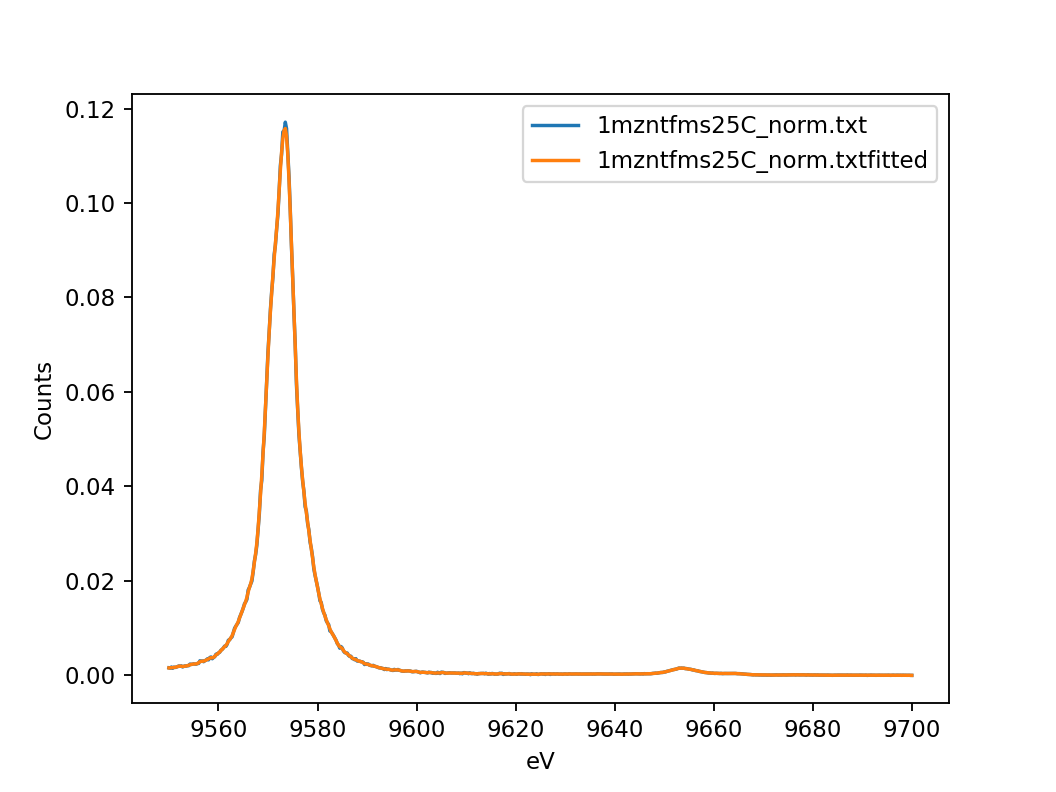

peak value: 9573.5


<IPython.core.display.Javascript object>


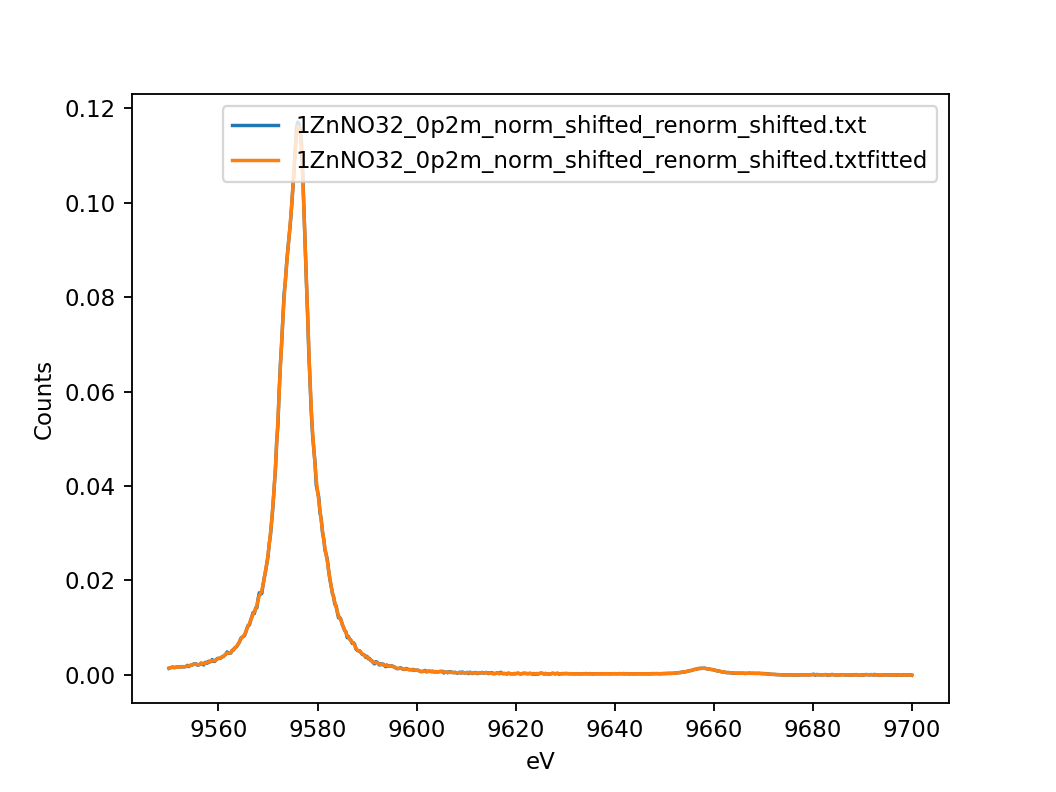

peak value: 9576.0


<IPython.core.display.Javascript object>


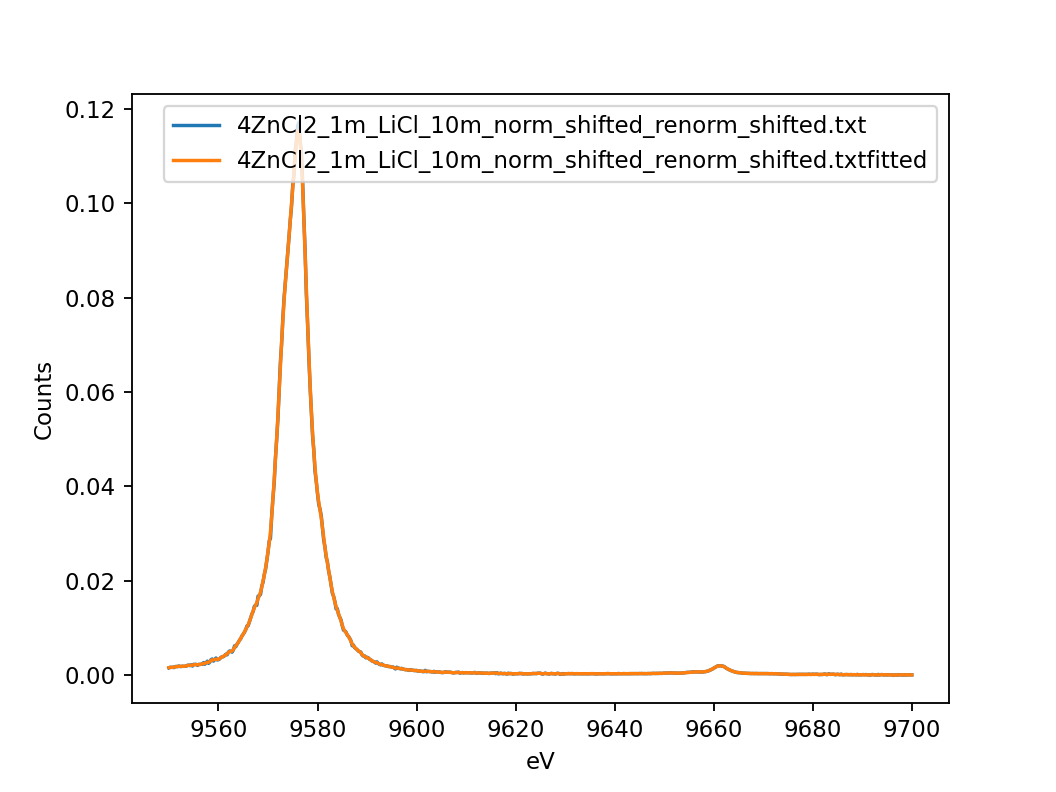

peak value: 9576.25


In [8]:
# Find peak position

def find_peak(df, xdata, ydata_list, min_with=0, min_dist=1, min_width=1, rel_prom=0.1, sigma=1):
    
    pk_E = []
    
    for ind, file in enumerate(ydata_list):
        smooth_data = gaussian_filter1d(df[file], sigma)
        peaks, pk_props = find_peaks(smooth_data, width=min_width, distance=min_dist, prominence=df[file].max()*rel_prom) 
        
        plt.figure(file)
        plt.xlabel('eV')
        plt.ylabel('Counts')
        #plot original data
        plt.plot(df[xdata], df[file], label=file)
        #plot the fitted data data
        plt.plot(df[xdata], smooth_data, label=file+'fitted')
        plt.legend(loc='upper right')
        
        for i in peaks:
            print('peak value:', df[xdata][i])
            pk_E.append(df[xdata][i])
    
    return pk_E
    
        
pk_E = find_peak(df,'Energy', file_list)

<IPython.core.display.Javascript object>


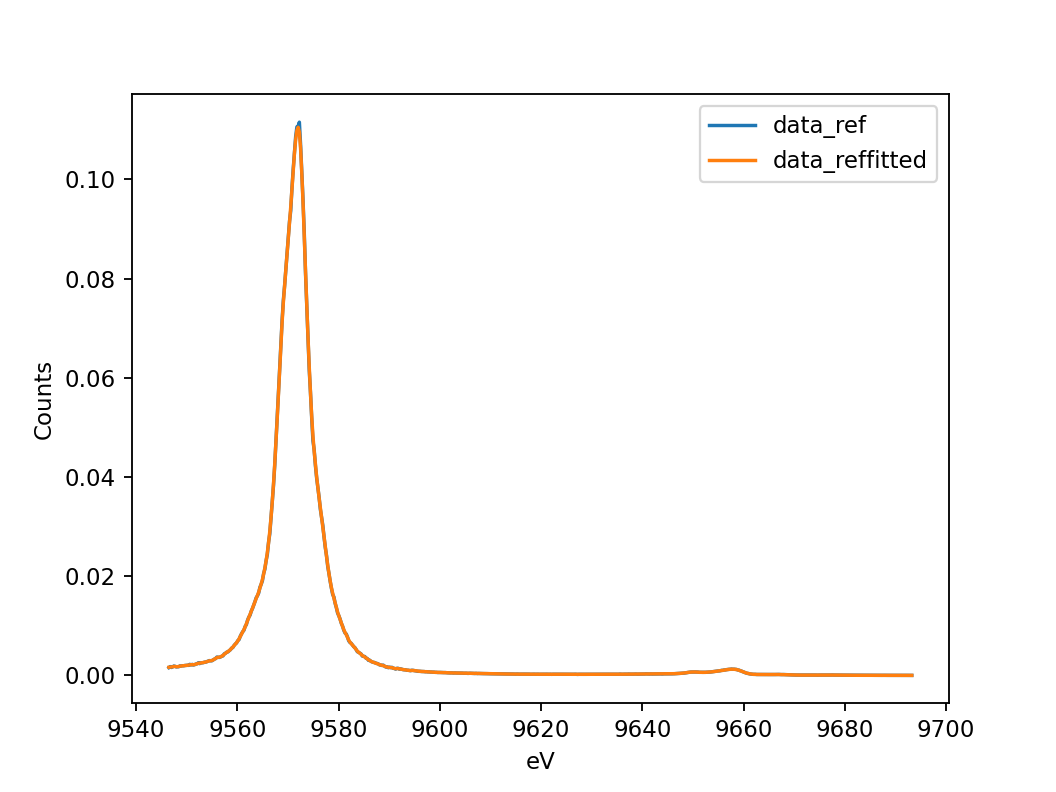

peak value: 9572.0


In [9]:
# Find peak energy for the reference spectra

pk_E_ref = find_peak(df_ref, 'E_ref', ['data_ref'])

In [10]:
# shift to align with the reference peak energy

# convert from energy to angle
ref_angle = f.convert_to_angle(pk_E_ref, 0.0653269) 
pk_angle = f.convert_to_angle(pk_E, 0.0653269)

# Find delta theta
delta_angle = -pk_angle + ref_angle[0]
print(ref_angle, pk_angle)
print(delta_angle)


# Put shifted energy back into the data frame
for ind, file in enumerate(file_list):
    angles = f.convert_to_angle(df['Energy'], 0.0653269)
    angles = angles + delta_angle[ind]
    shift_energies = f.convert_to_energy(angles, 0.0653269) 
    df['shifted E:'+file] = shift_energies
df

[82.47320992] [82.39435529 82.39435529 82.41679906 82.40556864 82.41679906 82.39435529
 82.39435529 82.40556864 82.41679906 82.40556864 82.41679906 82.39435529
 82.39435529 82.41679906 82.41679906 82.41679906 82.39435529 82.39435529
 82.41679906 82.41679906 82.41679906 82.39435529 82.39435529 82.41679906
 82.40556864 82.41679906 82.39435529 82.38315893 82.41679906 82.40556864
 82.40556864 82.38315893 82.38315893 82.40556864 82.29419104 82.28314434]
[0.07885463 0.07885463 0.05641086 0.06764128 0.05641086 0.07885463
 0.07885463 0.06764128 0.05641086 0.06764128 0.05641086 0.07885463
 0.07885463 0.05641086 0.05641086 0.05641086 0.07885463 0.07885463
 0.05641086 0.05641086 0.05641086 0.07885463 0.07885463 0.05641086
 0.06764128 0.05641086 0.07885463 0.09005099 0.05641086 0.06764128
 0.06764128 0.09005099 0.09005099 0.06764128 0.17901888 0.19006558]


Energy  1m0m115c_norm.txt  1m0m135c_norm.txt  1m0m25C_norm.txt  \
0    9550.00           0.001638           0.001524          0.001645   
1    9550.25           0.001593           0.001879          0.001572   
2    9550.50           0.001876           0.001457          0.001718   
3    9550.75           0.001445           0.001744          0.001645   
4    9551.00           0.001906           0.001744          0.001587   
..       ...                ...                ...               ...   
596  9699.00          -0.000011           0.000006         -0.000028   
597  9699.25          -0.000042          -0.000040         -0.000011   
598  9699.50           0.000001          -0.000011         -0.000011   
599  9699.75           0.000012          -0.000014         -0.000041   
600  9700.00           0.000021          -0.000017          0.000024   

     1m0m60C_norm.txt  1m0m90C_norm.txt  1m10m115C_norm.txt  \
0        1.748504e-03          0.001827            0.001701   
1        1.600849e-03          0.001483            0.001444   
2        1.674629e-03          0.001874            0.001216   
3        1.748479e-03          0.001602            0.001216   
4        1.615778e-03          0.001756            0.001701   
..                ...               ...                 ...   
596      4.858787e-07         -0.000015           -0.000035   
597     -1.008040e-06         -0.000032            0.000034   
598     -5.479854e-05         -0.000013            0.000014   
599      1.244051e-05         -0.000010           -0.000049   
600     -4.284339e-05         -0.000031            0.000014   

     1m10m135C_norm.txt  1m10m25C-controlled_norm.txt  1m10m25C_norm.txt  ...  \
0          1.689805e-03                      0.001814           0.001991  ...   
1          1.548864e-03                      0.001459           0.002299  ...   
2          1.831362e-03                      0.001374           0.001930  ...   
3          1.830932e-03                      0.002102           0.001684  ...   
4          1.831060e-03                      0.001239           0.001684  ...   
..                  ...                           ...                ...  ...   
596       -3.274211e-05                     -0.000035          -0.000049  ...   
597        5.935102e-07                     -0.000047          -0.000042  ...   
598       -8.930306e-06                      0.000052          -0.000033  ...   
599        5.350782e-06                     -0.000035          -0.000018  ...   
600       -5.177702e-05                      0.000018           0.000035  ...   

     shifted E:1m5m115c_norm.txt  shifted E:1m5m135c_norm.txt  \
0                    9548.523066                  9548.314863   
1                    9548.769949                  9548.561304   
2                    9549.016839                  9548.807753   
3                    9549.263735                  9549.054208   
4                    9549.510637                  9549.300670   
..                           ...                          ...   
596                  9696.189839                  9695.792453   
597                  9696.438067                  9696.040429   
598                  9696.686296                  9696.288407   
599                  9696.934525                  9696.536385   
600                  9697.182756                  9696.784364   

     shifted E:1m5m25C_norm.txt  shifted E:1m5m60C_norm.txt  \
0                   9548.941546                 9548.731959   
1                   9549.189316                 9548.979286   
2                   9549.437091                 9549.226618   
3                   9549.684870                 9549.473955   
4                   9549.932654                 9549.721297   
..                          ...                         ...   
596                 9696.987638                 9696.588233   
597                 9697.236370                 9696.836712   
598                 9697.485102                 9697.085193   


<IPython.core.display.Javascript object>


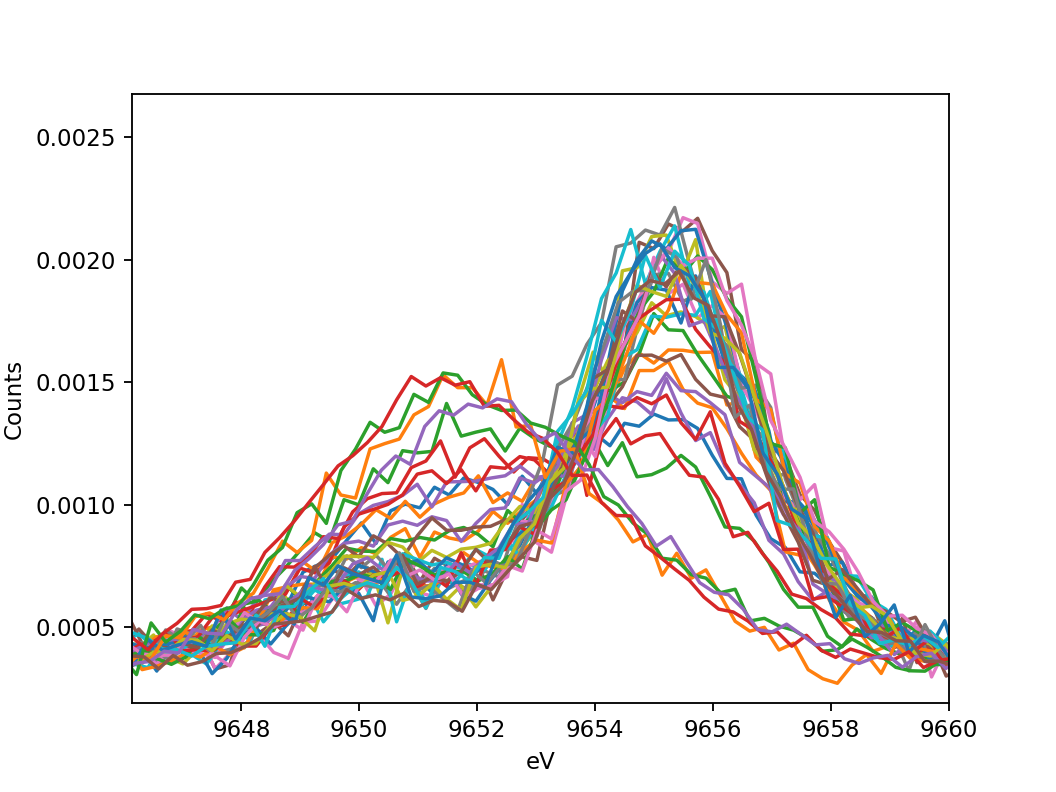

In [11]:
plt.figure('Shifted spectra')
plt.xlabel('eV')
plt.ylabel('Counts')

#plot shifted data
for file in file_list:
    plt.plot(df['shifted E:'+file], df[file], label=file)
    
#plt.legend(loc='upper right')